# OpenFDA Data
## Exploratory Analysis & Prediction of Seriousness of Adverse Reaction

## OpenFDA data

The U.S. Food and Drug Administration (FDA) regulates over-the-counter and prescription drugs in the United States, including biological therapeutics and generic drugs. This work covers more than just medicines.

The FDA's database of adverse event reports is made available through a web API at https://open.fda.gov/apis/drug/event/.

The data files are available for download.Alternatively, specific queries can be filed to access parts of the database under some restrictions on traffic (this is the approach followed here).

## Summary

The purpose of this investigation is to perform an initial exploratory analysis on adverse reactions report data from the OpenFDA database, identify interesting patterns or irregularities in the data and promising directions for their future use. It includes 2 parts.

The first part consists of exploring the data for issues (e.g. nonsensical or contradictory entries, outliers, mising data, evidence of bias) and interesting trends (relationships between variables, e.g. specific drugs & reactions, countries & seriousness of reactions, coinciding reactions, etc.). At every opportunity, we identify potential sources of bias and discuss directions for further investigation of these. 

The second part consists of trying to predict the seriousness of an adverse reaction given some of the patient's characteristics. In this context we perform feature selection, assessing the informativeness of each feature w.r.t. the target (Seriousness of reaction) using different information-theoretic feature selection methods. We relate the outcomes of feature selection with our findings in Part 1.

We then construct a classifier (the code allows for multiple options) evaluate its performance using several appropriate measures and discuss the intricacies of data preprocessing, handling imbalanced data and calibrating the scores of the classifier to obtain more reliable probabilistic estimates.

The analysis carried out here is performed based on only a small subset of reports: 
<br>
5000 reports related to patients receiving treatments for cancer, filed during the last 5 years.

It also only considers a small subset of the features:

i) The patient's gender,
<br>
ii) The patient's age group,
<br>
iii) The patients' weight,
<br>
iv) The patient's age at the onset of the event,
<br>
v) The drug's generic name,
<br>
vi) The country where the event occurred,
<br>
vii) The number of adverse reactions experienced by the patient,
<br>
viii) A list of up to 5 adverse reactions along with their corresponding outcomes, finally
<br>
ix) A binary variable describing the seriousness of their reaction, i.e. whether "the adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition" or it didn't.

The code is easily customisable to allow the inclusion of more reports (just change the parameter 'num_batches' in the first block of code ) and (with minor modifications) features in the future.

## Word of caution

OpenFDA reports are not verified by the FDA.

The is a wealth of data in these reports but the data do contain nonsensical or contradictory entries and mising data.

The reports are also biased and drawing any conclusions from these --especially for countries other than the US (we will see why in Part 1) should be done with extreme caution. 

Finally, the analysis carried out here is merely done to illustrate steps taken when analyzing data. It is performed on a very small subset of the data and only includes a very small subset of the available features.

# Part 1: Downloading & Cleaning Data

First we import some useful modules:

In [232]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.calibration import CalibratedClassifierCV

#Leave only for model used, comment rest:
#from sklearn import tree
from sklearn import ensemble
#from sklearn import linear_model
#from sklearn import neural_network
#from sklearn import neighbors

#Uncomment these lines to check if your version of the imported modules is up to date:
import matplotlib
import sklearn
print('The code has been tested using Requests version 2.22.0 / current version: '+requests.__version__)
print('The code has been tested using Numpy version 1.17.2 / current version: '+np.__version__)
print('The code has been tested using Pandas version 0.25.1 / current version: '+pd.__version__)
print('The code has been tested using Matplotlib version 3.1.1 / current version: '+matplotlib.__version__)
print('The code has been tested using Scikit-Learn version 0.23.1 / current version: '+sklearn.__version__)
print('The code has been tested using the skfeature package found at: https://github.com/jundongl/scikit-feature/tree/master/skfeature')

The code has been tested using Requests version 2.22.0 / current version: 2.22.0
The code has been tested using Numpy version 1.17.2 / current version: 1.17.2
The code has been tested using Pandas version 0.25.1 / current version: 0.25.1
The code has been tested using Matplotlib version 3.1.1 / current version: 3.1.1
The code has been tested using Scikit-Learn version 0.23.1 / current version: 0.23.1
The code has been tested using the skfeature package found at: https://github.com/jundongl/scikit-feature/tree/master/skfeature


## Next, we specify the data we request from OpenFDA:

Note OpenFDA imposes some limitations on the data requests:

1) A single URL request can return up to 1000 relevant results.
<br>
2) The user can skip results, but only up to a maximum of 25000.
<br>
3) There is a limit of 1,000 requests per day, per IP address for non-authorised users.

Limitations 1 & 2 mean that the maximum number of datapoints we can download is 26000, in this example we only operate on 5000. To increase the sample size, just increase the parameter 'num_batches'.



In [8]:
#Variables to control data request:
batch_size = 1000 #(Maximum) number of results to download per query from openfda
num_batches = 5 #Number of queries to submit to openfda
num_reactions = 5 #Number of different reactions with their outcome to store (as ordered in patient.reaction)
step = 1 #Step size when sampling openfda database (default:'1' to not omit any entry, i.e. collect first batch_size*batch_size) 

#Query Specification: (this example: a subset of all reports over the last 5 years related to cancer starting from oldest)
URL_related_disease = '"cancer"'
URL_received_date_range = '+AND+receivedate:[20150930+TO+20200930]'#i.e. last 5 years until September 30th
URL_base = 'https://api.fda.gov/drug/event.json?search='
URL_batch_size = '&limit='+str(batch_size)
URL = URL_base+URL_related_disease+URL_received_date_range+URL_batch_size

## Loading data

In [256]:
#Load Data
verbose = 0 # User defined; if 1 will inform you of each datapoint being loaded

X = []
for j in range(num_batches):
    #Load data from openfda:
    
    URL_j = URL + '&skip='+str(batch_size*j*step)
    print("Collecting data from openfda. Query submitted:")
    print(URL_j)
    data = requests.get(URL_j).json() 

    #Populate a table with variables of interest:   (Might modify/expand)
    #Default array values denote missing or non-applicable entries
    serious = np.zeros((len(data["results"]), 1))
    patient_sex = np.zeros((len(data["results"]), 1))
    patient_age_group = np.zeros((len(data["results"]), 1))
    patient_drug = np.full((len(data["results"]), 1), 'Unknown', dtype=object)  
    occurcountry = np.full((len(data["results"]), 1), 'Unknown', dtype=object)
    patient_reaction = np.full((len(data["results"]), num_reactions), 'None', dtype=object)
    patient_reaction_outcome = np.zeros((len(data["results"]), num_reactions))
    patient_num_reactions = np.zeros((len(data["results"]), 1))
    patient_weight = np.zeros((len(data["results"]), 1))
    patient_onset_age = np.ones((len(data["results"]), 1))*(-1)
    
    for i in range(len(data["results"])):
        if verbose == 1:
            print("Saving relevant data from: Batch "+str(j+1)+ " of "+str(num_batches)+", Datapoint "+str(i+1)+" of "+str((len(data["results"]))))
        if 'occurcountry' in data["results"][i]:
            occurcountry[i] = data["results"][i]["occurcountry"]
        if 'serious' in data["results"][i]:
            serious[i] = data["results"][i]["serious"]          #Be more specific about seriousness?
        if 'patientsex' in data["results"][i]["patient"]:
            patient_sex[i] = data["results"][i]["patient"]["patientsex"]
        if 'patientweight' in data["results"][i]["patient"]:
            patient_weight[i] = data["results"][i]["patient"]["patientweight"] 
        if 'patientonsetage' in data["results"][i]["patient"]:
            patient_onset_age[i] = data["results"][i]["patient"]["patientonsetage"]
        if 'patientagegroup' in data["results"][i]["patient"]:
            patient_age_group[i] = data["results"][i]["patient"]["patientagegroup"]
        if 'openfda' in data["results"][i]["patient"]["drug"][0]:
             if 'generic_name' in data["results"][i]["patient"]["drug"][0]["openfda"]:
                 patient_drug[i] = data["results"][i]["patient"]["drug"][0]["openfda"]["generic_name"][0] #If multiple names given, pick first. Use other drug identifier?
        patient_num_reactions[i] = len(data["results"][i]["patient"] ["reaction"])
        for k in range(num_reactions):
             if k < patient_num_reactions[i]-1:
                 if 'reactionmeddrapt' in data["results"][i]["patient"] ["reaction"][k]:
                     patient_reaction[i,k] = data["results"][i]["patient"] ["reaction"][k]['reactionmeddrapt']
                 if 'reactionoutcome' in data["results"][i]["patient"] ["reaction"][k]:
                     patient_reaction_outcome[i,k] = data["results"][i]["patient"] ["reaction"][k]['reactionoutcome']   

    #Concatenate variables of interest to form feature array:
    X_batch = np.concatenate((patient_sex, patient_weight, patient_onset_age, patient_age_group, patient_num_reactions, occurcountry, patient_drug, patient_reaction, patient_reaction_outcome, serious), axis=1)
    if j==0: #Initialize data array X on first batch:
        X = X_batch
    else: #Add last batch to data array X:
        X = np.concatenate((X,X_batch))
del data # Delete variable storing results of last openfda query to potentially save memory


#For convenience, turn X into a Pandas dataframe:
column_names = ["patient_sex", "patient_weight", "patient_onset_age", "patient_age_group", "patient_num_reactions", "occurcountry", "patient_drug"]
for k in range(num_reactions):
    column_names.append("patient_reaction_"+str(k+1))
for k in range(num_reactions):
    column_names.append("patient_reaction_outcome_"+str(k+1))
column_names.append("serious")
 
df = pd.DataFrame(data=X, columns=column_names).fillna(-1)#impute 'NaN' values with ''-1'

#Use some more recognizable labels for certain variables' values:
df.loc[(df.patient_sex == 0),'patient_sex'] = 'Unknown'
df.loc[(df.patient_sex == 1),'patient_sex'] = 'Male'
df.loc[(df.patient_sex == 2),'patient_sex'] = 'Female'
df.loc[(df.serious == 1),'serious'] = 'Serious'
df.loc[(df.serious == 2),'serious'] = 'Not Serious'
df.loc[(df.patient_age_group == 0),'patient_age_group'] = 'Unknown'
df.loc[(df.patient_age_group == 1),'patient_age_group'] = 'Neonate'
df.loc[(df.patient_age_group == 2),'patient_age_group'] = 'Infant'
df.loc[(df.patient_age_group == 3),'patient_age_group'] = 'Child'
df.loc[(df.patient_age_group == 4),'patient_age_group'] = 'Adolescent'
df.loc[(df.patient_age_group == 5),'patient_age_group'] = 'Adult'
df.loc[(df.patient_age_group == 6),'patient_age_group'] = 'Elderly'

df_raw = df #Keep a copy of the data, can e.g. use for comparisons after imputation/cleaning

https://api.fda.gov/drug/event.json?search="cancer"+AND+receivedate:[20150930+TO+20200930]&limit=1000&skip=0
https://api.fda.gov/drug/event.json?search="cancer"+AND+receivedate:[20150930+TO+20200930]&limit=1000&skip=1000
https://api.fda.gov/drug/event.json?search="cancer"+AND+receivedate:[20150930+TO+20200930]&limit=1000&skip=2000
https://api.fda.gov/drug/event.json?search="cancer"+AND+receivedate:[20150930+TO+20200930]&limit=1000&skip=3000
https://api.fda.gov/drug/event.json?search="cancer"+AND+receivedate:[20150930+TO+20200930]&limit=1000&skip=4000


## Simple sanity checks:

Let us first make sure we indeed downloaded the desired number of datapoints and features:

In [103]:
print('The downloaded data contain information from '+str(df.shape[0])+' OpenFDA reports related to cancer.')
print('The following '+str(df.shape[1])+' variables are stored for further analysis: ')
print(list(df.columns.values))

The downloaded data contain information from 5000 OpenFDA reports related to cancer.
The following 18 variables are stored for further analysis: 
['patient_sex', 'patient_weight', 'patient_onset_age', 'patient_age_group', 'patient_num_reactions', 'occurcountry', 'patient_drug', 'patient_reaction_1', 'patient_reaction_2', 'patient_reaction_3', 'patient_reaction_4', 'patient_reaction_5', 'patient_reaction_outcome_1', 'patient_reaction_outcome_2', 'patient_reaction_outcome_3', 'patient_reaction_outcome_4', 'patient_reaction_outcome_5', 'serious']


We can perform some sanity checks to see that the data entries make sense. For instance:

In [11]:
#Example sanity check - Count number of patients whose reaction was 'Fatal' (outcome 5), yet are marked as 'Not Serious' (number should be 0):
check_serious = df[(df["patient_reaction_outcome_1"] == 5) & (df.serious == 'Not Serious')].shape[0] + df[(df["patient_reaction_outcome_2"] == 5) & (df.serious == 'Not Serious')].shape[0] + df[(df["patient_reaction_outcome_3"] == 5) & (df.serious == 'Not Serious')].shape[0] + df[(df["patient_reaction_outcome_4"] == 5) & (df.serious == 'Not Serious')].shape[0] + df[(df["patient_reaction_outcome_5"] == 5) & (df.serious == 'Not Serious')].shape[0]
print('Result = '+str(check_serious)+' / Expected Result =  0')

Result = 0 / Expected Result =  0


The check above shows that the dataset does not (hopefully!) contain patients whose reaction outcome was 'Fatal', yet their reactions marked as 'Not Serious'.

Not all columns are as clean though! See the example below.

In [14]:
#Example sanity check - List patients whose onset age is greater than 110:
df_check = df[df.patient_onset_age > 110]
print(df_check["patient_onset_age"])

63      26865.0
170     27255.0
264     28773.0
271     23944.0
360       695.0
396     22873.0
425     25477.0
432     26514.0
603     19547.0
614     29610.0
858       115.0
1048    26800.0
1213      825.0
1224    13172.0
1303     8345.0
1385      502.0
1466    21985.0
1522    24525.0
1856      804.0
1897    30362.0
2136    25697.0
2148    30871.0
2251    29369.0
2352    22425.0
2353    23327.0
2570      715.0
2647    23558.0
2675    27233.0
2833    21965.0
2942    16938.0
2985      789.0
3413    27834.0
3590      790.0
3623    24382.0
3749    31100.0
3793    18372.0
3799    19532.0
3847      519.0
4126    28260.0
4299      752.0
4462    21231.0
4504    29481.0
4641    23253.0
4712      726.0
4794    27942.0
4801      759.0
4879    27735.0
4882    33329.0
Name: patient_onset_age, dtype: float64


Although age (in years) at event onset values like '115' might be valid, most of these entries are clearly nonsensical.

We shall not spend any more time performing such sanity checks on our data. The lesson here is that some of the variables might contain erroneous values or missing entries. 

Before using the data to derive any conclusions or to train any models, we should investigate extensively for such issues. Once we identify them, we can take measures to decrease their influence on further steps of the analysis.

## Use insights of sanity checks to do some data cleaning:

We saw above that the dataset contains several patients whose age at the onset of the event is clearly wrong. We can replace these with a missing value token to avoid using them:

In [15]:
#Data Cleaning example - Replace obviously wrong ages with '-1' for 'unknown':
df.loc[(df.patient_onset_age > 110),'patient_onset_age'] = -1
#df.loc[(df.patient_onset_age == 'NaN'),'patient_onset_age'] = -1

## Or to perform some imputation of missing data:

For example, many entries for the patient's gender are marked as 'Unknown', yet the patients can exhibit reactions that hint to their gender like e.g. 'Prostate Cancer' or 'Cervical Cancer'. We can use this information to impute the missing gender value.

Ideally, to impute 'Unknown' gender values, we have acces to a list of reactions not applicable to each gender (e.g. by exhaustively inspecting the list of reactions in the data and perhaps consulting domain experts). Note that the reactions listed just in this sample exceed 1500 and multiple ones are listed by the reporter under different names (e.g. entries "Disease Progression", "Breast Cancer Progression", "Malignant Neoplasm Progression", "Malignant Tumor Progression", and more, might refer to the same reaction: the patient's cancer progressing) --this is yet another issue we sould have to correct for proper analysis of the data in practice.

As a rough approximation to this, we perform imputation as follows: once we find that a certain reaction is only expressed in the data in Female (conversely Male) patients or patients of unknown gender, we can assume it is not applicable to Male (conversely Female) patients and all patients of unknown gender are imputed as Males (conversely Female).

Of course this is a simplistic assumption. These reactions might just be very rare for the other gender and this might be an effect of a small and/or biased dataset.

In [18]:
print('Patients of unknown gender before imputation: '+str(df[df.patient_sex == 'Unknown'].shape[0]))

#Data Imputation example - Use reactions to infer patient sex, if unspecified:
reaction_list = np.unique(X[:,7:7+num_reactions])
for i in range((len(reaction_list))):
    #Find all patients exhibiting reaction:  
    df_temp = df.loc[(df.patient_reaction_1 == reaction_list[i]) | (df.patient_reaction_2 == reaction_list[i]) | (df.patient_reaction_3 == reaction_list[i]) | (df.patient_reaction_4 == reaction_list[i]) | (df.patient_reaction_5 == reaction_list[i])]
    #If one gender's count is 0 for the i-th reaction, assume it is not applicable to said gender:
    if df_temp[df_temp['patient_sex']=='Male'].shape[0] == 0: #No males reported with this reaction
        #Impute all missing gender values as Female:
        df.loc[(df_temp.patient_sex == 'Unknown').index.values.tolist(),'patient_sex'] = 'Female'
    elif df_temp[df_temp['patient_sex']=='Female'].shape[0] == 0: #No females reported with this reaction
        #Impute all missing gender values as Male:
        df.loc[(df_temp.patient_sex == 'Unknown').index.values.tolist(),'patient_sex'] = 'Male'

print('Patients of unknown gender after imputation: '+str(df[df.patient_sex == 'Unknown'].shape[0]))

Patients of unknown gender before imputation: 615
Patients of unknown gender after imputation: 476


Let us now list the countries of event occurence, the drugs and the reactions reported by order of descending occurence in the data. This will be useful for later steps of the exploratory analysis.

In [138]:
#Find unique values for country, drug, reaction_list & their (relative) frequency of occurence:
remove_unknown = 1 #To not consider in the following visualisations entries marked as 'Unknown' 

country_list, country_counts = np.unique(df["occurcountry"], return_counts=True)
country_counts = (country_counts/len(df["occurcountry"]))*100 #Normalize by total to get relative frequency, multiply by 100 for percentage
country_counts_sorted_desc, country_list_sorted_desc = zip(*sorted(zip(country_counts, country_list), reverse=True))

drug_list, drug_counts = np.unique(df["patient_drug"], return_counts=True)
drug_counts = (drug_counts/len(df["patient_drug"]))*100 #Normalize by total to get relative frequency, multiply by 100 for percentage
drug_counts_sorted_desc, drug_list_sorted_desc = zip(*sorted(zip(drug_counts, drug_list), reverse=True))

reaction_list, reaction_counts = np.unique(df[["patient_reaction_1", "patient_reaction_2", "patient_reaction_3", "patient_reaction_4", "patient_reaction_5"]], return_counts=True)
reaction_counts = (reaction_counts/len(df["patient_reaction_1"]))*100 #Normalize by total to get relative frequency, multiply by 100 for percentage
reaction_counts_sorted_desc, reaction_list_sorted_desc = zip(*sorted(zip(reaction_counts, reaction_list), reverse=True))

if remove_unknown == 1:
    temp_country_list = list(country_list_sorted_desc)
    temp_country_counts_list = list(country_counts_sorted_desc)
    indx_to_remove = temp_country_list.index('Unknown')
    del temp_country_list[indx_to_remove]
    del temp_country_counts_list[indx_to_remove]
    country_list_sorted_desc = tuple(temp_country_list)
    country_counts_sorted_desc = tuple(temp_country_counts_list)

    temp_drug_list = list(drug_list_sorted_desc)
    temp_drug_counts_list = list(drug_counts_sorted_desc)
    indx_to_remove = temp_drug_list.index('Unknown')
    del temp_drug_list[indx_to_remove]
    del temp_drug_counts_list[indx_to_remove]
    drug_list_sorted_desc = tuple(temp_drug_list)
    drug_counts_sorted_desc = tuple(temp_drug_counts_list)    
    
    temp_reaction_list = list(reaction_list_sorted_desc)
    temp_reaction_counts_list = list(reaction_counts_sorted_desc)
    indx_to_remove = temp_reaction_list.index('None')
    del temp_reaction_list[indx_to_remove]
    del temp_reaction_counts_list[indx_to_remove]
    reaction_list_sorted_desc = tuple(temp_reaction_list)
    reaction_counts_sorted_desc = tuple(temp_reaction_counts_list)  

We can print these lists to see the countries, drugs & reactions associated with the reports. Remember, they are listed in order of number of appearances in the data (from most to least frequent).

In [139]:
print('The sample contains reports from '+str(len(country_list_sorted_desc))+' countries (excluding "Unknown").')
print('The listed countries, in descenting order of frequency of appearences are:')
print(country_list_sorted_desc)

The sample contains reports from 73 countries (excluding "Unknown").
The listed countries, in descenting order of frequency of appearences are:
('US', 'JP', 'CA', 'IT', 'FR', 'DE', 'GB', 'NL', 'BR', 'CO', 'CN', 'IN', 'AU', 'ES', 'KR', 'BE', 'CH', 'CZ', 'AT', 'AR', 'GR', 'IL', 'TW', 'DK', 'SE', 'PL', 'TR', 'MX', 'NO', 'VE', 'IE', 'FI', 'CL', 'PT', 'IR', 'HU', 'SA', 'RU', 'RO', 'PH', 'PE', 'ID', 'SK', 'HR', 'TH', 'NZ', 'MY', 'ZA', 'EC', 'BG', 'VN', 'UY', 'SG', 'RS', 'QA', 'PR', 'HK', 'GT', 'UA', 'TN', 'SI', 'SD', 'PK', 'PA', 'NG', 'MT', 'MA', 'LK', 'LB', 'GH', 'EG', 'CY', 'AM')


In [140]:
print('The sample contains reports on '+str(len(drug_list_sorted_desc))+' drugs (excluding "Unknown").')
print('The listed drugs (generic name), in descenting order of frequency of appearences are:')
print(drug_list_sorted_desc)

The sample contains reports on 445 drugs (excluding "Unknown").
The listed drugs (generic name), in descenting order of frequency of appearences are:
('PALBOCICLIB', 'TRASTUZUMAB', 'ENZALUTAMIDE', 'PANITUMUMAB', 'ABIRATERONE ACETATE', 'EVEROLIMUS', 'BEVACIZUMAB', 'LEUPROLIDE ACETATE', 'CAPECITABINE', 'LETROZOLE', 'NIVOLUMAB', 'LAPATINIB', 'DENOSUMAB', 'PAZOPANIB HYDROCHLORIDE', 'CARBOPLATIN', 'CISPLATIN', 'EXEMESTANE', 'DOCETAXEL', 'CETUXIMAB', 'SUNITINIB MALATE', 'PACLITAXEL', 'FLUOROURACIL', 'PERTUZUMAB', 'ADO-TRASTUZUMAB EMTANSINE', 'OXALIPLATIN', 'REGORAFENIB', 'ETANERCEPT', 'ZOLEDRONIC ACID', 'SORAFENIB', 'DOXORUBICIN', 'AFATINIB', 'PREDNISONE', 'LENVATINIB', 'METHOTREXATE', 'GEMCITABINE HYDROCHLORIDE', 'ANASTROZOLE', 'CYCLOPHOSPHAMIDE', 'ADALIMUMAB', 'FULVESTRANT', 'ETOPOSIDE', 'CRIZOTINIB', 'AXITINIB', 'ERLOTINIB HYDROCHLORIDE', 'DEXAMETHASONE 1.5 MG', 'PIOGLITAZONE', 'INFLIXIMAB', 'RADIUM RA 223 DICHLORIDE', 'PEGFILGRASTIM', 'INTERFERON BETA-1A', 'DIMETHYL FUMARATE', 'CERITINIB

In [141]:
print('The sample contains reports of '+str(len(reaction_list_sorted_desc))+' reactions (excluding "Unknown").')
print('The listed reactions, in descenting order of frequency of appearences are:')
print(reaction_list_sorted_desc)

The sample contains reports of 1673 reactions (excluding "Unknown").
The listed reactions, in descenting order of frequency of appearences are:
('Diarrhoea', 'Fatigue', 'Nausea', 'Disease progression', 'Death', 'Vomiting', 'Decreased appetite', 'Breast cancer', 'Malignant neoplasm progression', 'Dyspnoea', 'Asthenia', 'Off label use', 'Weight decreased', 'Pyrexia', 'Malaise', 'Anaemia', 'Pain', 'Headache', 'Rash', 'Neutropenia', 'Drug ineffective', 'Hypertension', 'Dizziness', 'White blood cell count decreased', 'Stomatitis', 'Product use issue', 'Arthralgia', 'Pain in extremity', 'Febrile neutropenia', 'Dehydration', 'Thrombocytopenia', 'Pneumonia', 'Breast cancer metastatic', 'Constipation', 'Abdominal pain', 'Neuropathy peripheral', 'Cough', 'Prostate cancer', 'Fall', 'Dysgeusia', 'Alopecia', 'Pruritus', 'Hot flush', 'Erythema', 'Back pain', 'Skin cancer', 'Platelet count decreased', 'Pulmonary embolism', 'Infection', 'Gait disturbance', 'Leukopenia', 'Hypotension', 'Sepsis', 'Palma

## Simple visualizations:

Let us now produce some simple single variable visualizations:

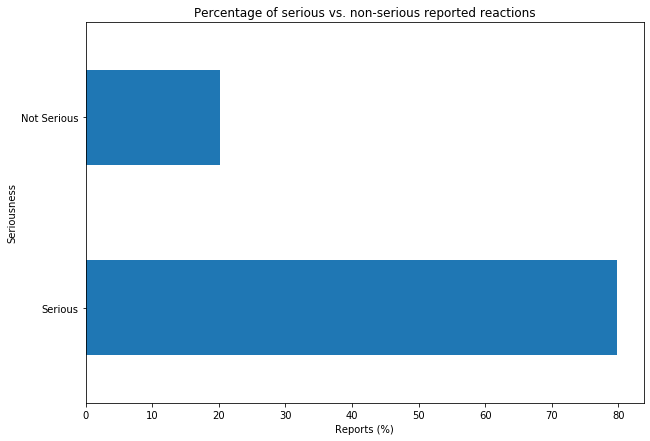

In [233]:
#Serious vs. not serious
plt.title("Percentage of serious vs. non-serious reported reactions")
df_plot = pd.Series(df["serious"]).value_counts()/len(df["serious"])*100
df_plot.plot(kind='barh')
plt.ylabel('Seriousness')
plt.xlabel('Reports (%)')
plt.gcf().set_size_inches(10, 7)

It appears that reports of serious reactions are about 4 times as frequent as those of not serious ones. 

Naturally, we would expect serious reactions to drugs to not be more frequent than not serious ones. Why is this not reflected in our sample?

There are several posibilities, e.g.:

1) The above expectation is true in general but not for (at least most types of) cancer. Remember that the subset of reports examined here is limited to cases related to cancer which is a life-threatening disease. It might be the case that:

a) Cancer-related therapies are more likely to yield serious adverse reactions than the average drug.

b) Cancer-related therapies are less likely to cure cancer than the average drug. The reactions we observe might not necessarily be due to the drugs but rather due to the  natural progression of the disease.

2) The OpenFDA reaction reports are biased towards serious cases as they are more likely to be reported (sampling bias).

Ideally we should consult domain experts when trying to understand the sources of bias in our data. At any rate, we should be careful when drawing conclusions for the general population from a specific data sample.

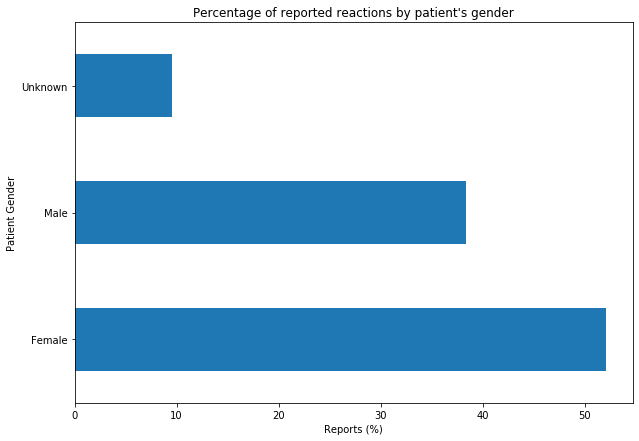

In [234]:
#Gender
plt.title("Percentage of reported reactions by patient's gender")
df_plot = pd.Series(df["patient_sex"]).value_counts()/len(df["patient_sex"])*100
df_plot.plot(kind='barh')
plt.ylabel('Patient Gender')
plt.xlabel('Reports (%)')
plt.gcf().set_size_inches(10, 7)

About 10% of the reports concern patients of unknown gender (even after our imputation attempt).

It appears that more reaction reports are filed for female patients.

There could also be multiple interpretations of this, e.g.:

1) Female patients are more likely to receive cancer treatment.
<br>
2) Female patients are more likely to experience adverse reactions to cancer treatments.
<br>
3) Female patients are more likely to report adverse reactions given they experience them.

Again, consulting with domain experts and cross-correlating the data with other sources would be necessary before drawing any conclusions.

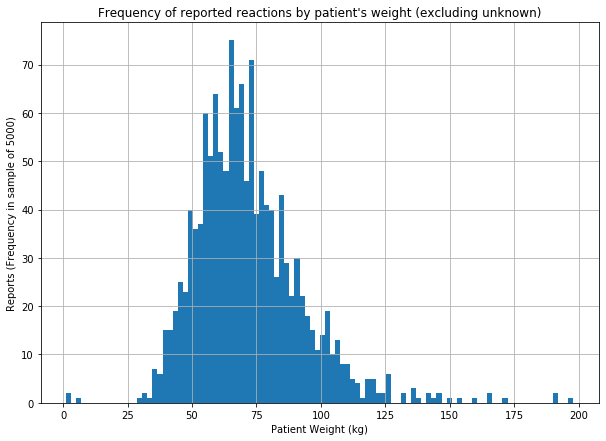

In [236]:
#Weight
exclude_unknown = 1 #exclude 'Unknown'(most common value, encoded as '0')

if exclude_unknown == 0:
    plt.title("Frequency of reported reactions by patient's weight")
    df["patient_weight"].hist(bins=100)
else:
    plt.title("Frequency of reported reactions by patient's weight (excluding unknown)")
    df_onset_known = df[df["patient_weight"]>0]
    df_onset_known["patient_weight"].hist(bins=100)
plt.xlabel('Patient Weight (kg)')
plt.ylabel('Reports (Frequency in sample of '+str(df.shape[0])+')')
plt.gcf().set_size_inches(10, 7)

The distribution of patrient weights looks sensible. There are some outliers but their values are plausible.

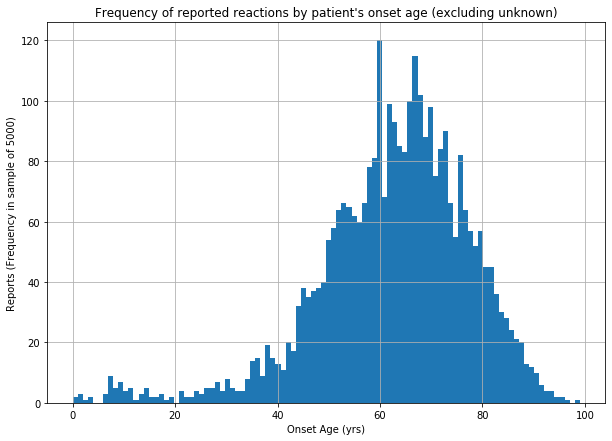

In [237]:
#Onset Age
exclude_unknown = 1 #exclude 'Unknown'(most common value, encoded as '-1')

if exclude_unknown == 0:
    plt.title("Frequency of reported reactions by patient's onset age")
    df["patient_onset_age"].hist(bins=100)
else:
    plt.title("Frequency of reported reactions by patient's onset age (excluding unknown)")
    df_onset_known = df[df["patient_onset_age"]>-1]
    df_onset_known["patient_onset_age"].hist(bins=100)
plt.xlabel('Onset Age (yrs)')
plt.ylabel('Reports (Frequency in sample of '+str(df.shape[0])+')')
plt.gcf().set_size_inches(10, 7)

The distribution of patrients' ages at the onset of the event also looks sensible, spanning a reasonable range of values.

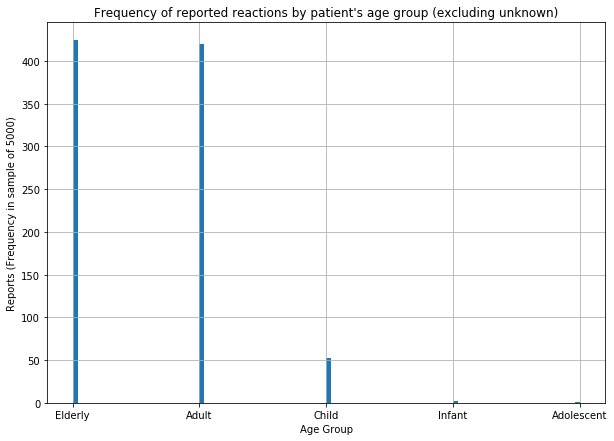

In [238]:
#Age Group
exclude_unknown = 1 #exclude 'Unknown'(most common value)

if exclude_unknown == 0:
    plt.title("Frequency of reported reactions by patient's age group")
    df["patient_age_group"].hist(bins=100)
else:
    plt.title("Frequency of reported reactions by patient's age group (excluding unknown)")
    df_age_group_known = df[df["patient_age_group"]!='Unknown']
    df_age_group_known["patient_age_group"].hist(bins=100)
plt.xlabel('Age Group')
plt.ylabel('Reports (Frequency in sample of '+str(df.shape[0])+')')
plt.gcf().set_size_inches(10, 7)

Interestingly, most reports concern adults and elderly. This is not surprising, as most cancers affect these age groups and the data concern reports for cancer medications. 

About 5% of the reports with known patient's age group concern children. Indeed, although rare, some types of cancer e.g. acute lymphoblastic leukaemia, occur most commonly (85%) in children under 5yrs old [1]. In the patient onset age histogram above, we do observe some onset ages in this range.

[1] Source: NHS (https://www.nhs.uk/conditions/acute-lymphoblastic-leukaemia/)

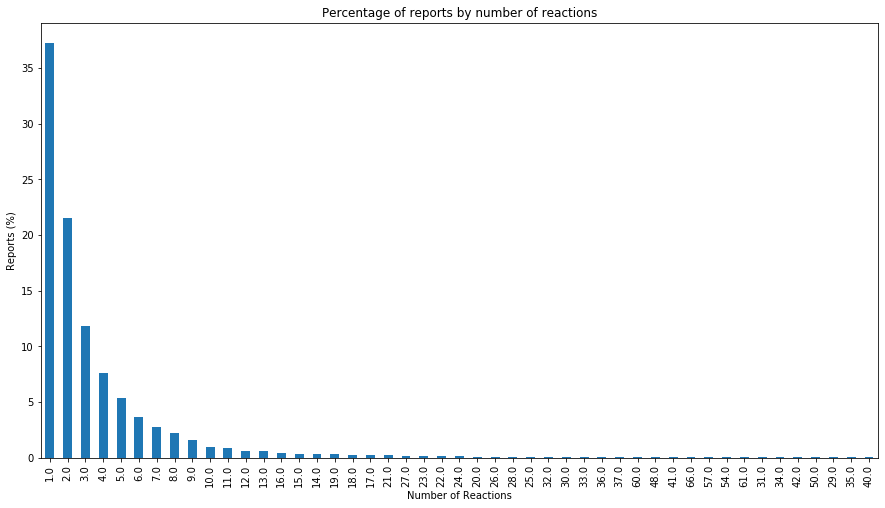

In [239]:
#Number of reactions
plt.title("Percentage of reports by number of reactions")
df_plot = pd.Series(df["patient_num_reactions"]).value_counts()/len(df["patient_num_reactions"])*100
df_plot.plot(kind='bar')
plt.xlabel('Number of Reactions')
plt.ylabel('Reports (%)')
plt.gcf().set_size_inches(15, 8)

Most patients report experiencing 1-10 reactions. But there are some rare extreme values of up to 40 reactions listed. We only kept up to the first 5 listed reactions, along with their outcomes for further exploration.

Out of the 73 countries listed in the reports, these 25 account for 90.04% of the total reports in the data.


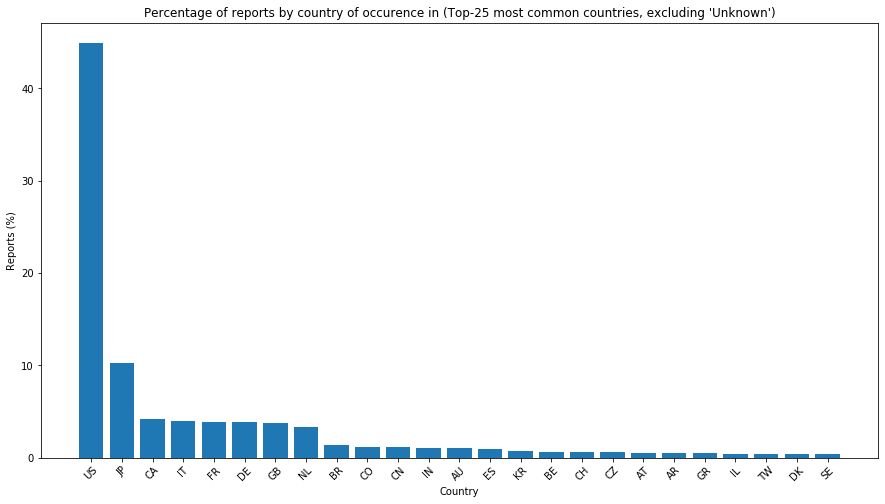

In [152]:
#Most common countries -- show top K
K = 25 #User defined; integer 1 to len(country_list_sorted_desc)

if remove_unknown == 1:
    plt.title("Percentage of reports by country of occurence in (Top-"+str(K)+" most common countries, excluding 'Unknown')")
else:
    plt.title("Percentage of reports by country of occurence in (Top-"+str(K)+" most common countries)")
plt.xticks(fontsize=10, rotation=45)
plt.bar(country_list_sorted_desc[:K], country_counts_sorted_desc[:K])
plt.xlabel('Country')
plt.ylabel('Reports (%)')
plt.gcf().set_size_inches(15, 8)

print('Out of the '+str(len(country_list_sorted_desc))+' countries listed in the reports, these '+str(K)+' account for '+str(np.sum(country_counts_sorted_desc[:K]))+'% of the total reports in the data.')

Not surprisingly, most reports originate from the US. The data are, after all, from the United States Food and Drug Administration. It is possible that most relevant reports occuring in the US make their way to the OpenFDA dataset.

The other countries that produce many reports are either countries with a large population (eg. India, China, Brasil) or countries with close political ties to the US (Japan, Canada, Australia, Colombia, Korea, European counties). In the latter case, it is possible that the relevant authorities for adverse reaction reports in these countries are closely affiliated with the FDA.

However, even populous countries like Russia, many African countries & many Asian countries do not make the list of top-25 countries by frequency of reports. Possibly because the relevant authority for adverse reaction reports in these countries is not the FDA (or affiliated with it).

The above is a clear indication that the sample of reports in OpenFDA is biased in terms of the country of origin of reports.

To try to alleviate the effect of this bias, ideally we would collect information from other relevant authorities besides the FDA, to have a more characteristic sample of patients from different countries.

The majority of cancers, some 90–95% of cases, are due to genetic mutations from environmental and lifestyle factors. The remaining 5–10% are due to inherited genetics[1]. As all these factors are highly country-specific, it is crucial when analysing, interpreting or modelling cancer-related data to have a sample spanning different countries.

[1]Source: Anand P, Kunnumakkara AB, Sundaram C, Harikumar KB, Tharakan ST, Lai OS, Sung B, Aggarwal BB. "Cancer is a preventable disease that requires major lifestyle changes". Pharmaceutical Research. 25 (9): 2097–116

Out of the 73 countries listed in the reports, these 25 only account for 0.74% of the total reports in the data.


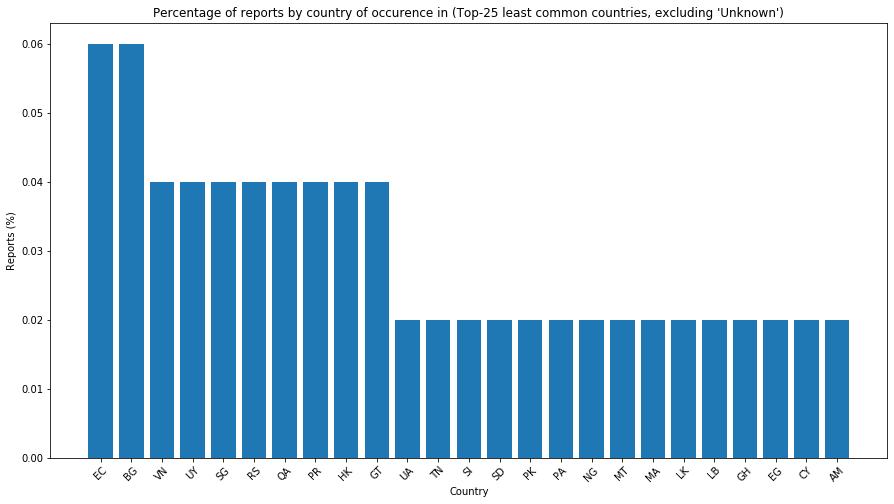

In [151]:
#Least common countries --Show top K
K = 25 #User defined; integer 1 to len(country_list_sorted_desc)

if remove_unknown == 1:
    plt.title("Percentage of reports by country of occurence in (Top-"+str(K)+" least common countries, excluding 'Unknown')")
else:
    plt.title("Percentage of reports by country of occurence in (Top-"+str(K)+" least common countries)")
plt.xticks(fontsize=10, rotation=45)
plt.bar(country_list_sorted_desc[-K:], country_counts_sorted_desc[-K:])
plt.xlabel('Country')
plt.ylabel('Reports (%)')
plt.gcf().set_size_inches(15, 8)

print('Out of the '+str(len(country_list_sorted_desc))+' countries listed in the reports, these '+str(K)+' only account for '+str(np.sum(country_counts_sorted_desc[-K:]))+'% of the total reports in the data.')

Continuing our observations above, the countries with the lowest frequency of appearence in the dataset are either countries with small populations or countries in which the main relevant authority for adverse reaction reports is not the FDA (or affiliated with it).

Out of the 445 drugs listed in the reports, these 10 account for 23.34% of the total reports in the data.


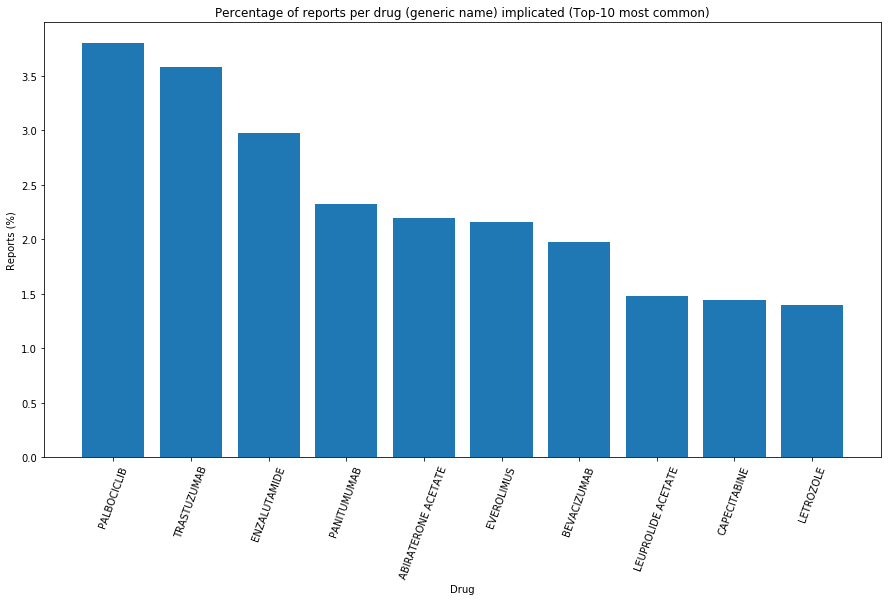

In [240]:
#Most common drugs --Show top K
K = 10 #User defined; integer 1 to len(drug_list_sorted_desc)

if exclude_unknown == 1:
    plt.title("Percentage of reports per drug (generic name) implicated (Top-"+str(K)+" most common)")
else:
    plt.title("Percentage of reports per drug (generic name) implicated (Top-"+str(K)+" most common, excluding 'Unknown')")
plt.bar(drug_list_sorted_desc[:K], drug_counts_sorted_desc[:K])
plt.xticks(fontsize=10, rotation=70)  
plt.xlabel('Drug')
plt.ylabel('Reports (%)')
plt.gcf().set_size_inches(15, 8)

print('Out of the '+str(len(drug_list_sorted_desc))+' drugs listed in the reports, these '+str(K)+' account for '+str(np.sum(drug_counts_sorted_desc[:K]))+'% of the total reports in the data.')

The listed drugs are indeed treatments administered to cancer patients. Note that although hundrends of drugs appear in our sample, these few account for a very large fraction of the adverse effect reports.

This might imply any of the following:

1) Patients are more likely to receive these drugs.
<br>
2) These drugs cause disproportionally more adverse reactions than others, if taken.
<br>
3) The reactions observed are due to natural disease progression. These drugs are administered to patients with more aggressive cancer cases. 
<br>
4) The reactions observed are due to natural disease progression. These drugs are not very suceessful at slowing it down.

A proper investigation of these hypothesis would require consulting with domain experts and cross-correlating the data with other sources.

Out of the 445 drugs listed in the reports, these 10 account for 0.19999999999999998% of the total reports in the data.


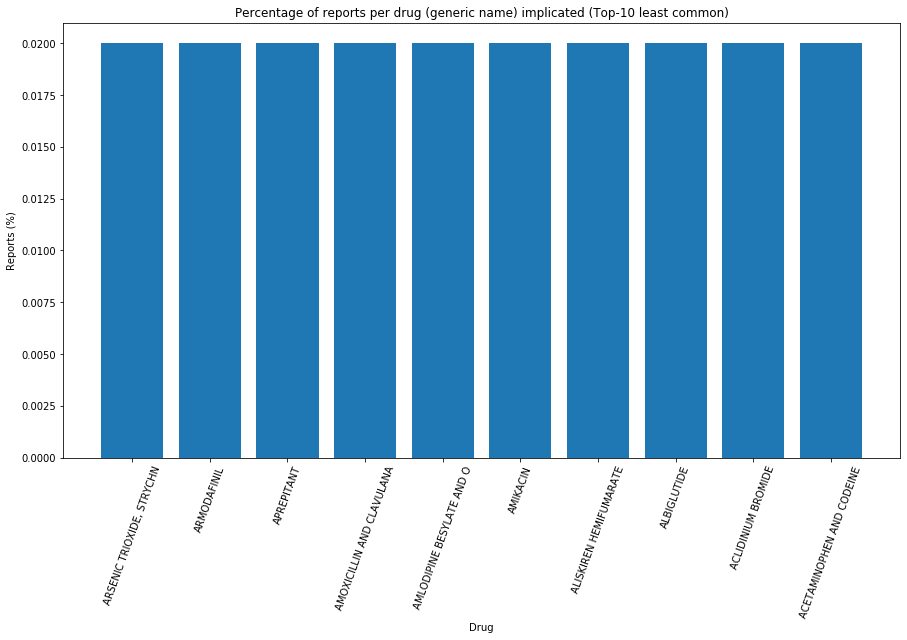

In [242]:
#Least common drugs --Show top K
K = 10 #User defined; integer 1 to len(drug_list_sorted_desc)

plt.title("Percentage of reports per drug (generic name) implicated (Top-"+str(K)+" least common)")
plt.xticks(fontsize=10, rotation=70)
drug_list_sorted_desc_truncated = [elem[:25] for elem in drug_list_sorted_desc[-K:]] #Some names are long; truncate for plot
plt.bar(drug_list_sorted_desc_truncated, drug_counts_sorted_desc[-K:])
plt.xlabel('Drug')
plt.ylabel('Reports (%)')
plt.gcf().set_size_inches(15, 8)

print('Out of the '+str(len(drug_list_sorted_desc))+' drugs listed in the reports, these '+str(K)+' account for '+str(np.sum(drug_counts_sorted_desc[-K:]))+'% of the total reports in the data.')

These drugs also appear to be used in cancer treatments. 

Out of the 1673 reactions listed in the reports, these 10 account for 25.639999999999997% of the total reports in the data.


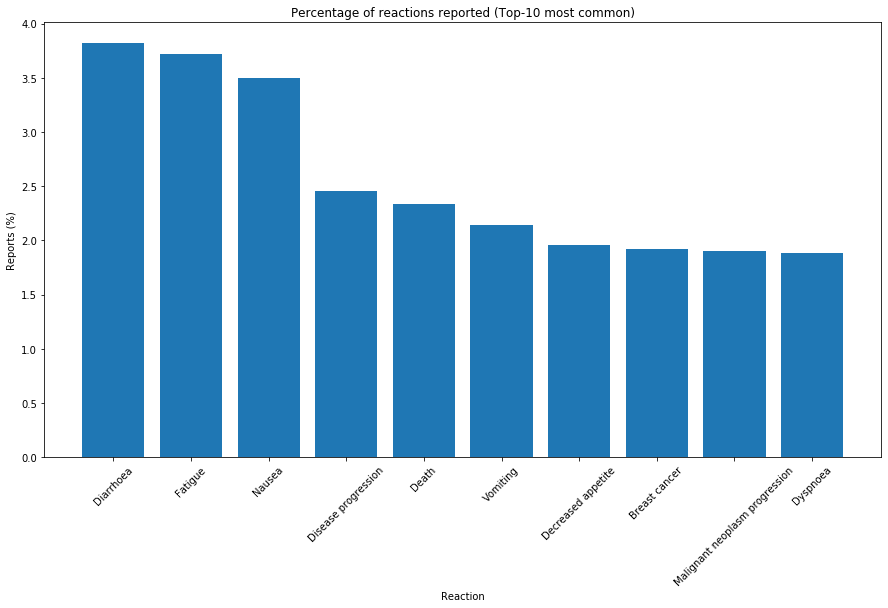

In [241]:
#Most common reactions --Show top K
K = 10 #User defined; integer 1 to len(reaction_list_sorted_desc)

plt.title("Percentage of reactions reported (Top-"+str(K)+" most common)")
plt.xticks(fontsize=10, rotation=45)
plt.bar(reaction_list_sorted_desc[:K], reaction_counts_sorted_desc[:K])
plt.xlabel('Reaction')
plt.ylabel('Reports (%)')
plt.gcf().set_size_inches(15, 8)

print('Out of the '+str(len(reaction_list_sorted_desc))+' reactions listed in the reports, these '+str(K)+' account for '+str(np.sum(reaction_counts_sorted_desc[:K]))+'% of the total reports in the data.')

Note that although hundrends of reactions appear in our sample, these few account for a very large fraction of the adverse effect reports.

The listed reactions (e.g. fatigue, vomiting, diarrhoea, nausea, decreased appetite) are common among patients receiving cancer treatments. They might be due to the main drug reported or other aspects of the treatment they receive.

These, as well as some other reactions like "Death", "Disease Progression", "Breast Cancer" or "Malignant Neoplasm Progression" could be results of natural disease progression and not so much of the drug administered or the overall treatment.

Note again that some of these e.g. "Disease Progression", "Breast Cancer" or "Malignant Neoplasm Progression" might refer to the same result under different names

Out of the 1673 reactions listed in the reports, these 10 account for 0.19999999999999998% of the total reports in the data.


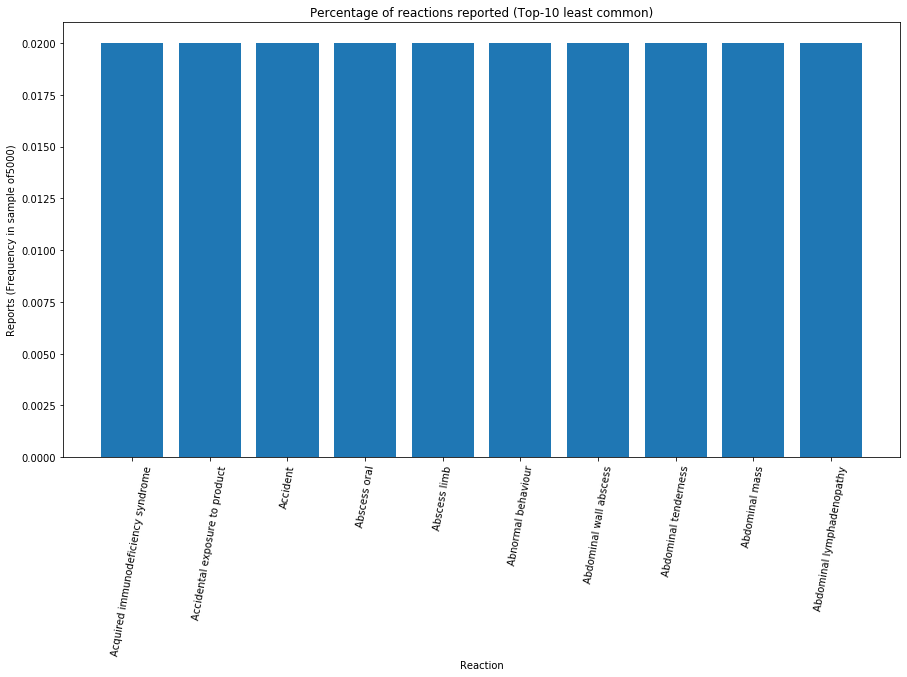

In [243]:
#Least common reactions --Show top K
K = 10 #User defined; integer 1 to len(reaction_list_sorted_desc)

plt.title("Percentage of reactions reported (Top-"+str(K)+" least common)")
plt.xticks(fontsize=10, rotation=80)
plt.bar(reaction_list_sorted_desc[-K:], reaction_counts_sorted_desc[-K:])
plt.xlabel('Reaction')
plt.ylabel('Reports (Frequency in sample of'+str(df.shape[0])+')')
plt.gcf().set_size_inches(15, 8)

print('Out of the '+str(len(reaction_list_sorted_desc))+' reactions listed in the reports, these '+str(K)+' account for '+str(np.sum(reaction_counts_sorted_desc[-K:]))+'% of the total reports in the data.')

The least commonly listed reactions include some more vague descriptions like "Abnormal Behaviour", "Accident". Some of these (e.g. "Accidental exposure to product") do not even appear to be actual side-effects to the drug itself, but rather an explanation of the patient's contact with the drug.

## Inspecting some empirical probabilities

Let us now investigate in some more depth the empirical distribution of the sample. We will calculate a set of empirical probabilities for each variable based on the report sample.

Some of these, we already inspected in the histograms above. Here we shall provide some  numbers for all these and quickly move on to conditional probabilities involving combinations of variables.

### Probabilities involving single variables (also covered by histograms above)

In [79]:
#Probability of serious reaction 
P_serious = df[df.serious == 'Serious'].shape[0] / df.shape[0]

print("Probability of serious reaction")
print('P(Serious) = '+str(P_serious))
print('P(Not Serious) = '+str(1 - P_serious)) 

Probability of serious reaction
P(Serious) = 0.7982
P(Not Serious) = 0.20179999999999998


In [162]:
#Probability of each gender: 
P_male = df[df.patient_sex == 'Male'].shape[0] / df.shape[0]
P_female = df[df.patient_sex == 'Female'].shape[0] / df.shape[0]

print("Probability of patient's gender (excluding unknown)")
print('P(Gender = Female) = '+str(P_female))    
print('P(Gender = Male) = '+str(P_male)) 

Probability of patient's gender (excluding unknown)
P(Gender = Female) = 0.5208
P(Gender = Male) = 0.384


In [164]:
#Probability of country (K most common countries):
K=10 #User defined; integer 1 to len(country_list_sorted_desc)

P_country = np.zeros((K, 1))
for k in range(K):
    P_country[k] = df[df.occurcountry == country_list_sorted_desc[k]].shape[0] / df.shape[0]

print("Probability of each country (excluding unknown)")
print("Countries ordered by frequency of reports.")
indices_sorted = np.flip(np.argsort(P_country.ravel()))
for i in range(len(P_country)):
    print('P(Country = '+country_list_sorted_desc[indices_sorted[i]]+') = '+str(P_country[indices_sorted[i]].item()))   

Probability of each country (excluding unknown)
Countries ordered by frequency of reports.
P(Country = US) = 0.4486
P(Country = JP) = 0.102
P(Country = CA) = 0.0414
P(Country = IT) = 0.0398
P(Country = FR) = 0.0388
P(Country = DE) = 0.038
P(Country = GB) = 0.037
P(Country = NL) = 0.033
P(Country = BR) = 0.0138
P(Country = CO) = 0.0116


In [165]:
#Probability of drug (K most common drugs):
K=10 #User defined; integer 1 to len(drug_list_sorted_desc)

P_drug = np.zeros((K, 1))
for k in range(K):
    P_drug[k] = df[df.patient_drug == drug_list_sorted_desc[k]].shape[0] / df.shape[0]
 
print("Probability of each drug (excluding unknown)")
print("Drugs ordered by frequency of reports.")
indices_sorted = np.flip(np.argsort(P_drug.ravel()))
for i in range(len(P_drug)):
    print('P(Drug = '+drug_list_sorted_desc[indices_sorted[i]]+') = '+str(P_drug[indices_sorted[i]].item()))   

Probability of each drug (excluding unknown)
Drugs ordered by frequency of reports.
P(Drug = PALBOCICLIB) = 0.038
P(Drug = TRASTUZUMAB) = 0.0358
P(Drug = ENZALUTAMIDE) = 0.0298
P(Drug = PANITUMUMAB) = 0.0232
P(Drug = ABIRATERONE ACETATE) = 0.022
P(Drug = EVEROLIMUS) = 0.0216
P(Drug = BEVACIZUMAB) = 0.0198
P(Drug = LEUPROLIDE ACETATE) = 0.0148
P(Drug = CAPECITABINE) = 0.0144
P(Drug = LETROZOLE) = 0.014


In [168]:
#Probability of reaction (K most common reactions):
K = 10 #User defined; integer 1 to len(reaction_list_sorted_desc)

P_reaction = np.zeros((K, 1))
for k in range(K):
    P_reaction[k] = df[((df.patient_reaction_1 == reaction_list_sorted_desc[k]) | (df.patient_reaction_2 == reaction_list_sorted_desc[k]) | (df.patient_reaction_3 == reaction_list_sorted_desc[k]) | (df.patient_reaction_4 == reaction_list_sorted_desc[k]) | (df.patient_reaction_5 == reaction_list_sorted_desc[k]))].shape[0] / df.shape[0]   

print("Probability of each reaction (excluding unknown)")
print("Reactions ordered by frequency of reports.")
indices_sorted = np.flip(np.argsort(P_reaction.ravel()))
for i in range(len(P_reaction)):
    print('P(Reaction = '+reaction_list_sorted_desc[indices_sorted[i]]+') = '+str(P_reaction[indices_sorted[i]].item()))   

Probability of each reaction (excluding unknown)
Reactions ordered by frequency of reports.
P(Reaction = Diarrhoea) = 0.0372
P(Reaction = Fatigue) = 0.0366
P(Reaction = Nausea) = 0.0348
P(Reaction = Disease progression) = 0.0246
P(Reaction = Death) = 0.0234
P(Reaction = Vomiting) = 0.0212
P(Reaction = Decreased appetite) = 0.0194
P(Reaction = Breast cancer) = 0.0192
P(Reaction = Malignant neoplasm progression) = 0.019
P(Reaction = Dyspnoea) = 0.0188


### Conditional probabilities involving pairs of variables (not covered by histograms)

Let us now investigate some conditional probabilities $P(A=a|B=b)$. That is, the probability that variable $A$ assumes value $a$ given another variable $B$ assumes value $b$.

In [77]:
#Probability of serious reaction given patient's gender:
P_serious_given_female = df[(df.serious == 'Serious') & (df.patient_sex == 'Female')].shape[0] / df[df.patient_sex == 'Female'].shape[0]
P_serious_given_male = df[(df.serious == 'Serious') & (df.patient_sex == 'Male')].shape[0] / df[df.patient_sex == 'Male'].shape[0]
#P_serious_given_unknown_gender = df[(df.serious == 'Serious') & (df.patient_sex == 'Unknown')].shape[0] / df[df.patient_sex == 'Unknown'].shape[0]

print("Probability of serious reaction given patient's gender; unknown excluded:")
print('P(Serious | Gender = Female) = '+str(P_serious_given_female))   
print('P(Serious | Gender = Male) = '+str(P_serious_given_male))   

Probability of serious reaction given patient's gender; unknown excluded:
P(Serious | Gender = Female) = 0.7588325652841782
P(Serious | Gender = Male) = 0.8453125


It appears that given that the patient is male, it is more likely that the reported reaction will be serious. There are several possible explanations for this e.g.:

1) Female patients are more likely to report less serious reactions if they experience them, compared to male patients.
<br>
2) Male patients are more likely to experience serious reactions (either due to the treatment or to natural disease progression), compared to female patients.

Further collaboration with domain experts and cross-reference to data from other sources would be needed to investigate these hypotheses.

In [78]:
#Probability of serious reaction given patient's age group (3 most common groups, excluding 'Unknown'):
P_serious_given_elderly = df[(df.serious == 'Serious') & (df.patient_age_group == 'Elderly')].shape[0] / df[df.patient_age_group == 'Elderly'].shape[0]
P_serious_given_adult = df[(df.serious == 'Serious') & (df.patient_age_group == 'Adult')].shape[0] / df[df.patient_age_group == 'Adult'].shape[0]
P_serious_given_child = df[(df.serious == 'Serious') & (df.patient_age_group == 'Child')].shape[0] / df[df.patient_age_group == 'Child'].shape[0]

print("Probability of serious reaction given patient's age group (only most prevalent)")
print('P(Serious | Age Group = Child) = '+str(P_serious_given_child))   
print('P(Serious | Age Group = Adult) = '+str(P_serious_given_adult)) 
print('P(Serious | Age Group = Elderly) = '+str(P_serious_given_elderly)) 

Probability of serious reaction given patient's age group (only most prevalent)
P(Serious | Age Group = Child) = 1.0
P(Serious | Age Group = Adult) = 0.7952380952380952
P(Serious | Age Group = Elderly) = 0.8325471698113207


It appears that given that the patient is an adult, it is less likely that the reported reaction will be serious (compared to children and elderly patients). Moreover, if the patient is a child, the probability is very high that the reaction is serious (in the dataset examined it is certain!).

There are several possible explanations for this e.g.:

1) Adults are more likely to report less serious reactions if they experience them, compared to other age groups.
<br>
2) Adults are less likely to experience serious reactions (either due to the treatment or to natural disease progression), compared to children or adults.

Further collaboration with domain experts and cross-reference to data from other sources would be needed to investigate these hypotheses.

In [173]:
#Probability of serious reaction given country of occurence (K most common countries):
K=25 #User defined; integer 1 to len(country_list_sorted_desc)

P_serious_given_country = np.zeros((K, 1))
for k in range(K):
    P_serious_given_country[k] = df[(df.serious == 'Serious') & (df.occurcountry == country_list_sorted_desc[k])].shape[0] / df[df.occurcountry == country_list_sorted_desc[k]].shape[0]

print("Probability of serious reaction given country")
print("The countries listed are the "+str(K)+" most frequent (excluding 'Unknown'), ordered by frequency.")
indices_sorted = np.argsort(P_serious_given_country.ravel())
for i in range(len(P_serious_given_country)):
    print('P(Serious | Country = '+country_list_sorted_desc[indices_sorted[i]]+') = '+str(P_serious_given_country[indices_sorted[i]].item()))   

Probability of serious reaction given country
The countries listed are the 25 most frequent (excluding 'Unknown'), ordered by frequency.
P(Serious | Country = US) = 0.6152474364690147
P(Serious | Country = TW) = 0.8947368421052632
P(Serious | Country = CN) = 0.9464285714285714
P(Serious | Country = CZ) = 0.9642857142857143
P(Serious | Country = JP) = 0.9725490196078431
P(Serious | Country = AU) = 0.98
P(Serious | Country = CA) = 0.9806763285024155
P(Serious | Country = NL) = 0.9939393939393939
P(Serious | Country = DE) = 0.9947368421052631
P(Serious | Country = IT) = 0.9949748743718593
P(Serious | Country = GB) = 1.0
P(Serious | Country = IL) = 1.0
P(Serious | Country = GR) = 1.0
P(Serious | Country = AR) = 1.0
P(Serious | Country = AT) = 1.0
P(Serious | Country = CH) = 1.0
P(Serious | Country = BE) = 1.0
P(Serious | Country = ES) = 1.0
P(Serious | Country = DK) = 1.0
P(Serious | Country = IN) = 1.0
P(Serious | Country = FR) = 1.0
P(Serious | Country = CO) = 1.0
P(Serious | Country = B

Again we see evidence of country-related bias in terms of the OpenFDA reports. But we also learn something new about the form of this bias:

Only serious reactions are reported for many countries. In fact, for most of the countries in this list, if a report appears in OpenFDA it is almost certainly serious. This is not the case for the US, however.

A likely explanation is that even not serious reaction cases are reported to OpenFDA from the US (e.g. by patients' doctors & local hospitals). A naive assumption is thus that that $P(Serious | Country = US) = 0.615$ is -although possibly still biased- closer to the true $P(Serious)$ in the population than the estimate for the later we get from this dataset ($=0.798$).

In [171]:
#Probability of serious reaction given drug (K most common drugs):
K=10 #User defined; integer 1 to len(drug_list_sorted_desc)

P_serious_given_drug = np.zeros((K, 1))
for k in range(K):
    P_serious_given_drug[k] = df[(df.serious == 'Serious') & (df.patient_drug == drug_list_sorted_desc[k])].shape[0] / df[df.patient_drug == drug_list_sorted_desc[k]].shape[0]

print("Probability of serious reaction given drug (generic name)")
print("The drugs listed are the "+str(K)+" most frequent in the reports (excluding 'Unknown').")
indices_sorted = np.flip(np.argsort(P_serious_given_drug.ravel()))
for i in range(len(P_serious_given_drug)):
    print('P(Serious | Drug = '+drug_list_sorted_desc[indices_sorted[i]]+') = '+str(P_serious_given_drug[indices_sorted[i]].item()))   

Probability of serious reaction given drug (generic name)
The drugs listed are the 10 most frequent in the reports (excluding 'Unknown').
P(Serious | Drug = BEVACIZUMAB) = 1.0
P(Serious | Drug = ENZALUTAMIDE) = 0.9664429530201343
P(Serious | Drug = LEUPROLIDE ACETATE) = 0.8918918918918919
P(Serious | Drug = CAPECITABINE) = 0.8888888888888888
P(Serious | Drug = ABIRATERONE ACETATE) = 0.7363636363636363
P(Serious | Drug = EVEROLIMUS) = 0.6944444444444444
P(Serious | Drug = LETROZOLE) = 0.5428571428571428
P(Serious | Drug = TRASTUZUMAB) = 0.4972067039106145
P(Serious | Drug = PALBOCICLIB) = 0.4263157894736842
P(Serious | Drug = PANITUMUMAB) = 0.29310344827586204


Again the probabilities are illuminating. Some drugs' reports are almost exclusively accompanied with a serious reaction. For instance, the drug BEVACIZUMAB is only associated with serious reports. A simple Wikipedia search confirms that indeed the drug is associated with severe side effects[1].

There is definitely information here about (i) either the severity of the cancer type for which the drug is administered or (ii) the severity of the adverse effect the drugs carry.

A proper further investigation of this would require collaboration with domain experts and data from other sources.

[1]Source: https://en.wikipedia.org/wiki/Bevacizumab#Adverse_effects

Next, we will calculate conditional probabilities for 

1) Each reaction given each drug
<br>
2) Each reaction given country of occurence
<br>
3) Each drug given country of occurence
<br>
4) Each reaction given some other reaction

We shall not list these exhaustively, but rather print heat maps showing that indeed some values of these conditional probability tables are much higher than others. We will then select these highest values to showcase them.

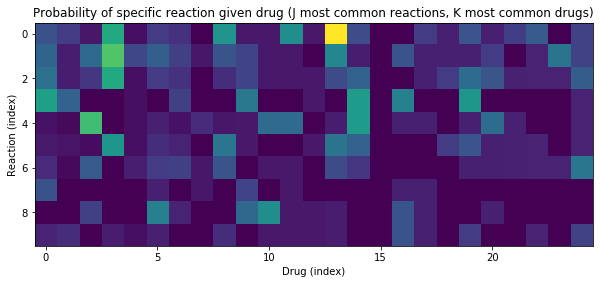

In [177]:
#Probability of specific reaction given drug (J most common reactions, K most common drugs):
J = 10 #User defined; integer 1 to len(reaction_list_sorted_desc)
K = 25 #User defined; integer 1 to len(drug_list_sorted_desc)

P_reaction_given_drug = np.zeros((J, K))
for j in range(J):
    for k in range(K):
        P_reaction_given_drug[j,k] = df[((df.patient_reaction_1 == reaction_list_sorted_desc[j]) | (df.patient_reaction_2 == reaction_list_sorted_desc[j]) | (df.patient_reaction_3 == reaction_list_sorted_desc[j]) | (df.patient_reaction_4 == reaction_list_sorted_desc[j]) | (df.patient_reaction_5 == reaction_list_sorted_desc[j])) & (df.patient_drug == drug_list_sorted_desc[k])].shape[0] / df[df.patient_drug == drug_list_sorted_desc[k]].shape[0]

plt.title("Probability of specific reaction given drug (J most common reactions, K most common drugs)")
plt.ylabel('Reaction (index)')
plt.xlabel('Drug (index)')
plt.imshow(P_reaction_given_drug) 
plt.gcf().set_size_inches(10, 7)

Indeed we see that certain reactions are a lot more likely than others (lighter areas) given that the patient is reporting being treated by certain drugs. Yet other reactions are very unlikely given certai drugs (darker areas).

We will now provide a list of the M most probable reactions given certain drugs. 

In [196]:
#Most common reactions per drug (show M most common)
M = 10 #User defined; integer 1 to J*K

# Convert it into a 1D array
P_1d = P_reaction_given_drug.flatten()
# Find the indices in the 1D array
idx_1d = np.flip(P_1d.argsort()[-M:])
# Convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, P_reaction_given_drug.shape)
print("Most common reactions given drug:")
for x, y, in zip(x_idx, y_idx):
    print("Patients taking drug '"+drug_list_sorted_desc[x]+ "' tend to exhibit reaction '" +reaction_list_sorted_desc[y]+ "' w.p. "+str(P_reaction_given_drug[x][y]))

Most common reactions given drug:
Patients taking drug 'PALBOCICLIB' tend to exhibit reaction 'Pyrexia' w.p. 0.21311475409836064
Patients taking drug 'TRASTUZUMAB' tend to exhibit reaction 'Disease progression' w.p. 0.15517241379310345
Patients taking drug 'ABIRATERONE ACETATE' tend to exhibit reaction 'Nausea' w.p. 0.1476510067114094
Patients taking drug 'ENZALUTAMIDE' tend to exhibit reaction 'Disease progression' w.p. 0.12931034482758622
Patients taking drug 'PALBOCICLIB' tend to exhibit reaction 'Disease progression' w.p. 0.12931034482758622
Patients taking drug 'PANITUMUMAB' tend to exhibit reaction 'Diarrhoea' w.p. 0.12105263157894737
Patients taking drug 'ABIRATERONE ACETATE' tend to exhibit reaction 'Malaise' w.p. 0.11666666666666667
Patients taking drug 'PANITUMUMAB' tend to exhibit reaction 'Malaise' w.p. 0.11666666666666667
Patients taking drug 'PANITUMUMAB' tend to exhibit reaction 'Neutropenia' w.p. 0.11320754716981132
Patients taking drug 'EVEROLIMUS' tend to exhibit reac

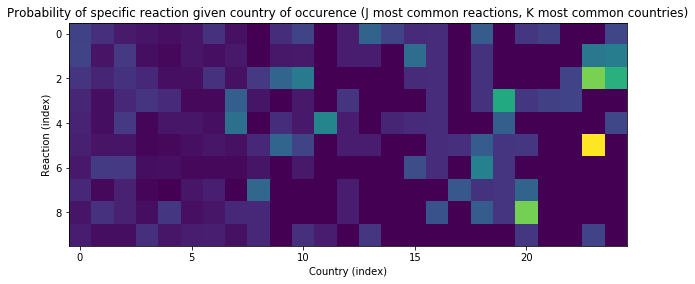

In [178]:
#Probability of specific reaction given country of occurence (J most common reactions, K most common countries)
J = 10 #User defined; integer 1 to len(reaction_list_sorted_desc)
K = 25 #User defined; integer 1 to len(country_list_sorted_desc)

P_reaction_given_country = np.zeros((J, K))
for j in range(J):
    for k in range(K):
        P_reaction_given_country[j,k] = df[((df.patient_reaction_1 == reaction_list_sorted_desc[j]) | (df.patient_reaction_2 == reaction_list_sorted_desc[j]) | (df.patient_reaction_3 == reaction_list_sorted_desc[j]) | (df.patient_reaction_4 == reaction_list_sorted_desc[j]) | (df.patient_reaction_5 == reaction_list_sorted_desc[j])) & (df.occurcountry == country_list_sorted_desc[k])].shape[0] / df[df.occurcountry == country_list_sorted_desc[k]].shape[0]

plt.title("Probability of specific reaction given country of occurence (J most common reactions, K most common countries)")
plt.ylabel('Reaction (index)')
plt.xlabel('Country (index)')
plt.imshow(P_reaction_given_country) 
plt.gcf().set_size_inches(10, 7)

Indeed we see that certain reactions are a lot more likely than others (lighter areas) given specific reported countries of occurence. Yet other reactions are very unlikely given certain countries (darker areas).

We will now list the M most common reactions for a given country:

In [198]:
#Most common reactions per country (show M most common)
M = 10 #User defined; integer 1 to J*K
# Convert it into a 1D array
P_1d = P_reaction_given_country.flatten()
# Find the indices in the 1D array
idx_1d = np.flip(P_1d.argsort()[-M:])
# Convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, P_reaction_given_country.shape)
print("Most common reactions given country")
for x, y, in zip(x_idx, y_idx):
    print("Reports from '"+country_list_sorted_desc[x]+ "' tend to include reaction '" +reaction_list_sorted_desc[y]+ "' w.p. "+str(P_reaction_given_country[x][y]))

Most common reactions given country
Reports from 'DE' tend to include reaction 'White blood cell count decreased' w.p. 0.2631578947368421
Reports from 'CA' tend to include reaction 'White blood cell count decreased' w.p. 0.21052631578947367
Reports from 'BR' tend to include reaction 'Drug ineffective' w.p. 0.20833333333333334
Reports from 'CA' tend to include reaction 'Stomatitis' w.p. 0.16666666666666666
Reports from 'IT' tend to include reaction 'Neutropenia' w.p. 0.16
Reports from 'FR' tend to include reaction 'Off label use' w.p. 0.12
Reports from 'GB' tend to include reaction 'Rash' w.p. 0.11538461538461539
Reports from 'JP' tend to include reaction 'Stomatitis' w.p. 0.1111111111111111
Reports from 'CA' tend to include reaction 'Asthenia' w.p. 0.10714285714285714
Reports from 'JP' tend to include reaction 'White blood cell count decreased' w.p. 0.10526315789473684


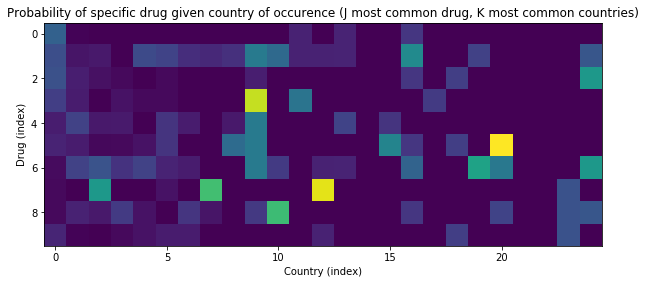

In [179]:
#Probability of specific drug given country of occurence (J most common drugs, K most common countries)
J = 10 #User defined; integer 1 to len(drug_list_sorted_desc)
K = 25 #User defined; integer 1 to len(country_list_sorted_desc)

P_drug_given_country = np.zeros((J, K))
for j in range(J):
    for k in range(K):
        P_drug_given_country[j,k] = df[(df.patient_drug == drug_list_sorted_desc[j]) & (df.occurcountry == country_list_sorted_desc[k])].shape[0] / df[df.occurcountry == country_list_sorted_desc[k]].shape[0]

plt.title("Probability of specific drug given country of occurence (J most common drug, K most common countries)")
plt.ylabel('Drug (index)')
plt.xlabel('Country (index)')
plt.imshow(P_drug_given_country) 
plt.gcf().set_size_inches(10, 7)

Indeed we see that certain drugs are a lot more likely than others (lighter areas) given specific reported countries of occurence. Yet other drugs are very unlikely given certain countries (darker areas).

We will now provide a list of the M most probable drugs given specific countries:

In [197]:
#Most common drugs per country (show M most common)
M = 10 #User defined; integer 1 to J*K

# Convert it into a 1D array
P_1d = P_drug_given_country.flatten()
# Find the indices in the 1D array
idx_1d = np.flip(P_1d.argsort()[-M:])
# Convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, P_drug_given_country.shape)
print("Most common drugs given country:")
for x, y, in zip(x_idx, y_idx):
    print("Reports from '"+country_list_sorted_desc[x]+ "' tend to include drug '" +drug_list_sorted_desc[y]+ "' w.p. "+str(P_drug_given_country[x][y]))

Most common drugs given country:
Reports from 'DE' tend to include drug 'PACLITAXEL' w.p. 0.20833333333333334
Reports from 'NL' tend to include drug 'DENOSUMAB' w.p. 0.2
Reports from 'IT' tend to include drug 'LETROZOLE' w.p. 0.1896551724137931
Reports from 'NL' tend to include drug 'LEUPROLIDE ACETATE' w.p. 0.14545454545454545
Reports from 'BR' tend to include drug 'NIVOLUMAB' w.p. 0.14285714285714285
Reports from 'GB' tend to include drug 'SUNITINIB MALATE' w.p. 0.12
Reports from 'CA' tend to include drug 'OXALIPLATIN' w.p. 0.1111111111111111
Reports from 'NL' tend to include drug 'ENZALUTAMIDE' w.p. 0.1111111111111111
Reports from 'GB' tend to include drug 'OXALIPLATIN' w.p. 0.1111111111111111
Reports from 'JP' tend to include drug 'EXEMESTANE' w.p. 0.1


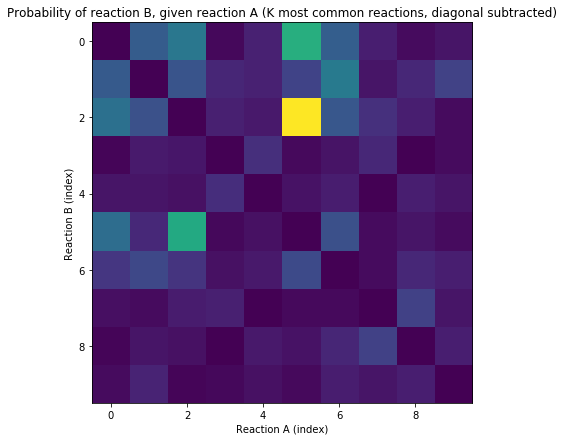

In [182]:
#Probability of having one reaction given another: (K most common reactions)
K = 10 #User defined; integer 1 to len(reaction_list_sorted_desc)

J = K
P_reaction_given_reaction = np.zeros((J, K))
for j in range(J):
    for k in range(K):
        P_reaction_given_reaction[j,k] = df[((df.patient_reaction_1 == reaction_list_sorted_desc[j]) | (df.patient_reaction_2 == reaction_list_sorted_desc[j]) | (df.patient_reaction_3 == reaction_list_sorted_desc[j]) | (df.patient_reaction_4 == reaction_list_sorted_desc[j]) | (df.patient_reaction_5 == reaction_list_sorted_desc[j])) & (((df.patient_reaction_1 == reaction_list_sorted_desc[k]) | (df.patient_reaction_2 == reaction_list_sorted_desc[k]) | (df.patient_reaction_3 == reaction_list_sorted_desc[k]) | (df.patient_reaction_4 == reaction_list_sorted_desc[k]) | (df.patient_reaction_5 == reaction_list_sorted_desc[k])))].shape[0] / df[((df.patient_reaction_1 == reaction_list_sorted_desc[k]) | (df.patient_reaction_2 == reaction_list_sorted_desc[k]) | (df.patient_reaction_3 == reaction_list_sorted_desc[k]) | (df.patient_reaction_4 == reaction_list_sorted_desc[k]) | (df.patient_reaction_5 == reaction_list_sorted_desc[k]))].shape[0]

#Subtract diagonal (obviously P(reaction = i|reaction = i)=1 for all i)
P_reaction_given_reaction_no_diag = P_reaction_given_reaction - np.identity(P_reaction_given_reaction.shape[0])    
        
plt.title("Probability of reaction B, given reaction A (K most common reactions, diagonal subtracted)")
plt.ylabel('Reaction B (index)')
plt.xlabel('Reaction A (index)')
plt.imshow(P_reaction_given_reaction_no_diag) 
plt.gcf().set_size_inches(10, 7)

We have subtracted the main diagonal as it is naturally equal to 1 for all reactions.

Indeed we see that certain reactions are a lot more likely than others (lighter areas) given certain other reactions.

Note that the table is close to symmetric, yet not exactly! This is sensible as this is a conditional probability table, not a joint probability table.

Reactions like "Nausea" and "Vomiting" are expected to be often experienced together, so their joint probability $P(Reaction = "Nausea", Reaction = "Vomiting")$ should be high. Yet, their conditional probabilities $P(Reaction = "Nausea" | Reaction = "Vomiting")$ and $P(Reaction = "Vomiting" | Reaction = "Nausea")$ can differ arbitrarily.

Since there is also a causal path: "Nausea" -- > "Vomiting" we might expect the probability $P(Reaction = "Vomiting" | Reaction = "Nausea")$ to be higher than $P(Reaction = "Nausea"| Reaction = "Vomiting")$.

Let us now print the M highest values from the conditional probability table:

In [193]:
#Most commonly coinciding reactions (show M most common)
M = 10 ##User defined; integer 1 to K^2
# Convert it into a 1D array
P_1d = P_reaction_given_reaction_no_diag.flatten()
# Find the indices in the 1D array
idx_1d = np.flip(P_1d.argsort()[-M:])
# Convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, P_reaction_given_reaction_no_diag.shape)
print("Most common reactions given another one:")
for x, y, in zip(x_idx, y_idx):
    print("Patients with reaction '"+reaction_list_sorted_desc[x]+ "' also tend to have reaction '" +reaction_list_sorted_desc[y]+ "' w.p. "+str(P_reaction_given_reaction[x][y]))

Most common reactions given another one:
Patients with reaction 'Nausea' also tend to have reaction 'Vomiting' w.p. 0.37735849056603776
Patients with reaction 'Diarrhoea' also tend to have reaction 'Vomiting' w.p. 0.2358490566037736
Patients with reaction 'Vomiting' also tend to have reaction 'Nausea' w.p. 0.22988505747126436
Patients with reaction 'Fatigue' also tend to have reaction 'Decreased appetite' w.p. 0.15463917525773196
Patients with reaction 'Diarrhoea' also tend to have reaction 'Nausea' w.p. 0.14942528735632185
Patients with reaction 'Nausea' also tend to have reaction 'Diarrhoea' w.p. 0.13978494623655913
Patients with reaction 'Vomiting' also tend to have reaction 'Diarrhoea' w.p. 0.13440860215053763
Patients with reaction 'Diarrhoea' also tend to have reaction 'Decreased appetite' w.p. 0.1134020618556701
Patients with reaction 'Diarrhoea' also tend to have reaction 'Fatigue' w.p. 0.1092896174863388
Patients with reaction 'Fatigue' also tend to have reaction 'Diarrhoea' w

The results make sense to anyone that has experienced these reactions.

Note that our hypothesis above regarding $P(Reaction = "Vomiting" | Reaction = "Nausea")$ being higher than $P(Reaction = "Nausea"| Reaction = "Vomiting")$ is validated.

Similar cases can be made for other reaction combinations.

In [183]:
#Probability of having a serious reaction given its type (K most common reactions):
K = 10 # #User defined; integer 1 to len(reaction_list_sorted_desc)

P_serious_given_reaction = np.zeros((K, 1))
for k in range(K):
    P_serious_given_reaction[k] = df[(df.serious == 'Serious') & (((df.patient_reaction_1 == reaction_list_sorted_desc[k]) | (df.patient_reaction_2 == reaction_list_sorted_desc[k]) | (df.patient_reaction_3 == reaction_list_sorted_desc[k]) | (df.patient_reaction_4 == reaction_list_sorted_desc[k]) | (df.patient_reaction_5 == reaction_list_sorted_desc[k])))].shape[0] / df[((df.patient_reaction_1 == reaction_list_sorted_desc[k]) | (df.patient_reaction_2 == reaction_list_sorted_desc[k]) | (df.patient_reaction_3 == reaction_list_sorted_desc[k]) | (df.patient_reaction_4 == reaction_list_sorted_desc[k]) | (df.patient_reaction_5 == reaction_list_sorted_desc[k]))].shape[0]

print("Probability of serious reaction given its type;")
indices_sorted = np.flip(np.argsort(P_serious_given_reaction.ravel()))
for i in range(len(P_serious_given_reaction)):
    print('P(Serious | Reaction = '+reaction_list_sorted_desc[indices_sorted[i]]+') = '+str(P_serious_given_reaction[indices_sorted[i]].item()))   

Probability of serious reaction given its type;
P(Serious | Reaction = Malignant neoplasm progression) = 1.0
P(Serious | Reaction = Death) = 1.0
P(Serious | Reaction = Breast cancer) = 0.9166666666666666
P(Serious | Reaction = Dyspnoea) = 0.8829787234042553
P(Serious | Reaction = Decreased appetite) = 0.7835051546391752
P(Serious | Reaction = Vomiting) = 0.7452830188679245
P(Serious | Reaction = Nausea) = 0.7068965517241379
P(Serious | Reaction = Diarrhoea) = 0.6451612903225806
P(Serious | Reaction = Disease progression) = 0.6422764227642277
P(Serious | Reaction = Fatigue) = 0.6120218579234973


Disregarding the obvious reaction "Death" which is certainly serious, we see that many other reactions with serious outcomes are those that do not slow down the disease progression. It might be that the drugs are simply ineffective in these cases, rather than causally contributing to an adverse reaction.

In [185]:
#Probability of specific country given gender (K most common countries):
K = 10 #User defined; integer 1 to len(country_list_sorted_desc)

P_country_given_male = np.zeros((K, 1)) 
P_country_given_female = np.zeros((K, 1)) 
for k in range(K):
    P_country_given_male[k] = df[(df.occurcountry == country_list_sorted_desc[k]) & (df.patient_sex == 'Male')].shape[0] / df[df.patient_sex == 'Male'].shape[0]
    P_country_given_female[k] = df[(df.occurcountry == country_list_sorted_desc[k]) & (df.patient_sex == 'Female')].shape[0] / df[df.patient_sex == 'Female'].shape[0]

print("Probability of country given patient's gender (most common countries regardless of gender)")
print("Female patients:")
indices_sorted_f = np.flip(np.argsort(P_country_given_female.ravel()))
for i in range(len(P_country_given_female)):
    print('P(Country = '+country_list_sorted_desc[indices_sorted_f[i]]+' | Gender = Female) = '+str(P_country_given_female[indices_sorted_f[i]].item()))   
print("Male Patients:")
indices_sorted_m = np.flip(np.argsort(P_country_given_male.ravel()))
for i in range(len(P_country_given_male)):
    print('P(Country = '+country_list_sorted_desc[indices_sorted_m[i]]+' | Gender = Male) = '+str(P_country_given_male[indices_sorted_m[i]].item()))   

Probability of country given patient's gender (most common countries regardless of gender)
Female patients:
P(Country = US | Gender = Female) = 0.4807987711213518
P(Country = JP | Gender = Female) = 0.07872503840245776
P(Country = GB | Gender = Female) = 0.043394777265745005
P(Country = FR | Gender = Female) = 0.03955453149001536
P(Country = DE | Gender = Female) = 0.03763440860215054
P(Country = IT | Gender = Female) = 0.03763440860215054
P(Country = CA | Gender = Female) = 0.03456221198156682
P(Country = BR | Gender = Female) = 0.018433179723502304
P(Country = CO | Gender = Female) = 0.013440860215053764
P(Country = NL | Gender = Female) = 0.013056835637480798
Male Patients:
P(Country = US | Gender = Male) = 0.41354166666666664
P(Country = JP | Gender = Male) = 0.13020833333333334
P(Country = DE | Gender = Male) = 0.04635416666666667
P(Country = NL | Gender = Male) = 0.04375
P(Country = CA | Gender = Male) = 0.043229166666666666
P(Country = IT | Gender = Male) = 0.03697916666666667
P

Quite a large percentage of male patients appear to be from Japan. 

We saw earlier that in our sample males account for a minority of reports with  $P(Gender = Male) = 0.384$. We also saw that reports from Japan are quite frequent, with $P(Country = Japan) = 0.102$ and that $P(Country = Japan | Gender = Male) = 0.130$.

A simple application of the Bayes Rule would give us:

$P(Gender = Male | Country = Japan) =  \frac{P(Country = Japan | Gender = Male)\times P(Gender = Male)}{P(Country = Japan)} = \frac {0.130 \times 0.384}{0.102} = 0.489$.

i.e. Japanese male patients are considerably more represented in the sample than the global $P(Gender = Male) = 0.384$. This is just an example of analysis we can perform given such conditional probabilities.

In [186]:
#Probability of specific drug given gender (K most common drugs):
K = 10 #User defined; integer 1 to len(drug_list_sorted_desc)

P_drug_given_male = np.zeros((K, 1)) 
P_drug_given_female = np.zeros((K, 1)) 
for k in range(K):
    P_drug_given_male[k] = df[(df.patient_drug == drug_list_sorted_desc[k]) & (df.patient_sex == 'Male')].shape[0] / df[df.patient_sex == 'Male'].shape[0]
    P_drug_given_female[k] = df[(df.patient_drug == drug_list_sorted_desc[k]) & (df.patient_sex == 'Female')].shape[0] / df[df.patient_sex == 'Female'].shape[0]

print("Probability of drug given patient's gender (for most common drugs regardless of gender)")
print("Female patients:")
indices_sorted_f = np.flip(np.argsort(P_drug_given_female.ravel()))
for i in range(len(P_drug_given_female)):
    print('P(Drug = '+drug_list_sorted_desc[indices_sorted_f[i]]+' | Gender = Female) = '+str(P_drug_given_female[indices_sorted_f[i]].item()))   
print("Male Patients:")
indices_sorted_m = np.flip(np.argsort(P_reaction_given_male.ravel()))
for i in range(len(P_drug_given_male)):
    print('P(Drug = '+drug_list_sorted_desc[indices_sorted_m[i]]+' | Gender = Male) = '+str(P_drug_given_male[indices_sorted_m[i]].item()))   

Probability of drug given patient's gender (for most common drugs regardless of gender)
Female patients:
P(Drug = PALBOCICLIB | Gender = Female) = 0.0695084485407066
P(Drug = TRASTUZUMAB | Gender = Female) = 0.05414746543778802
P(Drug = EVEROLIMUS | Gender = Female) = 0.03533026113671275
P(Drug = LETROZOLE | Gender = Female) = 0.02534562211981567
P(Drug = BEVACIZUMAB | Gender = Female) = 0.02304147465437788
P(Drug = PANITUMUMAB | Gender = Female) = 0.019969278033794162
P(Drug = CAPECITABINE | Gender = Female) = 0.015360983102918587
P(Drug = LEUPROLIDE ACETATE | Gender = Female) = 0.002304147465437788
P(Drug = ABIRATERONE ACETATE | Gender = Female) = 0.0
P(Drug = ENZALUTAMIDE | Gender = Female) = 0.0
Male Patients:
P(Drug = TRASTUZUMAB | Gender = Male) = 0.004166666666666667
P(Drug = PALBOCICLIB | Gender = Male) = 0.0015625
P(Drug = ENZALUTAMIDE | Gender = Male) = 0.07708333333333334
P(Drug = ABIRATERONE ACETATE | Gender = Male) = 0.05572916666666667
P(Drug = BEVACIZUMAB | Gender = Male

No female patient in the sample received the drugs "ABIRATERONE ACETATE" or "ENZALUTAMIDE". This is not surprising as these are both prostate cancer drugs[1,2]

Similarly, no male patient received the drug "LETROZOLE". Again, this is sensible as it is a medicine used for treating breast cancer, mainly prescribed for women who have been through menopause[3].

[1]Source: https://en.wikipedia.org/wiki/Abiraterone_acetate
[2]Source: https://en.wikipedia.org/wiki/Enzalutamide
[3]Source: NHS (https://www.nhs.uk/medicines/letrozole/)

In [92]:
#Probability of specific reaction given gender (K most common reactions):
K = 10 #User defined; integer 1 to len(reaction_list_sorted_desc)

P_reaction_given_male = np.zeros((K, 1)) 
P_reaction_given_female = np.zeros((K, 1)) 
for k in range(K):
    P_reaction_given_male[k] = df[((df.patient_reaction_1 == reaction_list_sorted_desc[k]) | (df.patient_reaction_2 == reaction_list_sorted_desc[k]) | (df.patient_reaction_3 == reaction_list_sorted_desc[k]) | (df.patient_reaction_4 == reaction_list_sorted_desc[k]) | (df.patient_reaction_5 == reaction_list_sorted_desc[k])) & (df.patient_sex == 'Male')].shape[0] / df[df.patient_sex == 'Male'].shape[0]
    P_reaction_given_female[k] = df[((df.patient_reaction_1 == reaction_list_sorted_desc[k]) | (df.patient_reaction_2 == reaction_list_sorted_desc[k]) | (df.patient_reaction_3 == reaction_list_sorted_desc[k]) | (df.patient_reaction_4 == reaction_list_sorted_desc[k]) | (df.patient_reaction_5 == reaction_list_sorted_desc[k])) & (df.patient_sex == 'Female')].shape[0] / df[df.patient_sex == 'Female'].shape[0]

print("Probability of reaction given patient's gender (most common reactions regardless of gender)")
print("Female patients:")
indices_sorted_f = np.flip(np.argsort(P_reaction_given_female.ravel()))
for i in range(len(P_reaction_given_female)):
    print('P(Reaction = '+reaction_list_sorted_desc[indices_sorted_f[i]]+' | Gender = Female) = '+str(P_reaction_given_female[indices_sorted_f[i]].item()))   
print("Male Patients:")
indices_sorted_m = np.flip(np.argsort(P_reaction_given_male.ravel()))
for i in range(len(P_reaction_given_male)):
    print('P(Reaction = '+reaction_list_sorted_desc[indices_sorted_m[i]]+' | Gender = Male) = '+str(P_reaction_given_male[indices_sorted_m[i]].item()))   

Probability of reaction given patient's gender (most common reactions regardless of gender)
Female patients:
P(Reaction = Nausea | Gender = Female) = 0.04109062980030722
P(Reaction = Fatigue | Gender = Female) = 0.04032258064516129
P(Reaction = Diarrhoea | Gender = Female) = 0.03917050691244239
P(Reaction = Breast cancer | Gender = Female) = 0.03494623655913978
P(Reaction = Disease progression | Gender = Female) = 0.026113671274961597
P(Reaction = Vomiting | Gender = Female) = 0.024193548387096774
P(Reaction = Malignant neoplasm progression | Gender = Female) = 0.02304147465437788
P(Reaction = Dyspnoea | Gender = Female) = 0.02227342549923195
P(Reaction = Death | Gender = Female) = 0.016129032258064516
P(Reaction = Decreased appetite | Gender = Female) = 0.014976958525345621
Male Patients:
P(Reaction = Fatigue | Gender = Male) = 0.03802083333333333
P(Reaction = Diarrhoea | Gender = Male) = 0.036458333333333336
P(Reaction = Nausea | Gender = Male) = 0.030208333333333334
P(Reaction = Dea

Naturally, incidence of breast cancer among male patients is far lower than among female patients. 

We can make some other interesting observations too. For instance, male patients appear more likely to die from the reaction (based on our sample at least):

In [191]:
P_death_given_male = 0.029166666666666667
P_death_given_female = 0.016129032258064516
OR_death_male = P_death_given_male / (1-P_death_given_male)
OR_death_female =  P_death_given_female / (1-P_death_given_female)
Rel_OR_death_male_to_female = OR_death_male/OR_death_female

print('The relative odds ratio for death of males compared to females is: '+str(Rel_OR_death_male_to_female))

The relative odds ratio for death of males compared to females is: 1.832618025751073


In [192]:
#Probability of outcome given reaction (K most common reactions):
K = 10 #User defined; integer 1 to len(reaction_list_sorted_desc)

all_reactions = df["patient_reaction_1"].append(df["patient_reaction_2"]).append(df["patient_reaction_3"]).append(df["patient_reaction_4"]).append(df["patient_reaction_5"]).to_numpy()
all_outcomes = df["patient_reaction_outcome_1"].append(df["patient_reaction_outcome_2"]).append(df["patient_reaction_outcome_3"]).append(df["patient_reaction_outcome_4"]).append(df["patient_reaction_outcome_5"]).to_numpy()
J = 6 # outcomes are encoded 1-6 (do not modify to consider all)
P_outcome_given_reaction = np.zeros((J, K))
for j in range(J):
    for k in range(K):
        P_outcome_given_reaction[j,k] = np.count_nonzero((all_outcomes == j+1) & (all_reactions == reaction_list_sorted_desc[k])) / np.count_nonzero(all_reactions == reaction_list_sorted_desc[k])

outcome_legend =  ["Recovered/resolved", "Recovering/resolving",
                   "Not recovered/not resolved",
                   "Recovered/resolved with sequelae", "Fatal", "Unknown"]

print('Most common outcome for each reaction (among known)')
for i in range(P_outcome_given_reaction.shape[1]):
    indices_sorted = np.flip(np.argsort(P_outcome_given_reaction[:,i].ravel()))
    most_common = indices_sorted[0]
    if outcome_legend[most_common] == "Unknown":
        most_common = indices_sorted[1]
    print('For reaction "'+reaction_list_sorted_desc[i]+'" most common outcome is "'+outcome_legend[most_common]+'" with probability: '+str(P_outcome_given_reaction[most_common, i].item()))   

Most common outcome for each reaction (among known)
For reaction "Diarrhoea" most common outcome is "Recovered/resolved" with probability: 0.25654450261780104
For reaction "Fatigue" most common outcome is "Not recovered/not resolved" with probability: 0.24193548387096775
For reaction "Nausea" most common outcome is "Recovered/resolved" with probability: 0.2571428571428571
For reaction "Disease progression" most common outcome is "Fatal" with probability: 0.21138211382113822
For reaction "Death" most common outcome is "Fatal" with probability: 1.0
For reaction "Vomiting" most common outcome is "Recovered/resolved" with probability: 0.29906542056074764
For reaction "Decreased appetite" most common outcome is "Not recovered/not resolved" with probability: 0.1836734693877551
For reaction "Breast cancer" most common outcome is "Not recovered/not resolved" with probability: 0.14583333333333334
For reaction "Malignant neoplasm progression" most common outcome is "Fatal" with probability: 0.32

Some reactions are not as life-threatening or long-lasting as others  (e.g. "Diarrhoea", "Nausea", "Vomiting", "Dyspnoea") and most commonly the patient recovers. Others like "Disease progression" or "Malignant neoplasm progression" and -naturally- "Death" are typically fatal.

Interestingly, "Decreased appetite" seems to not be resolved  in most cases.

This concludes our exploratory data analysis part. In the next part we shall define a supervised learning task using the OpenFDA reports sample we downloaded and demonstrate  an exaple of how to solve it.

## Part 2: Supervised task - Seriousness prediction

For the remainder of this report we shall address the problem of predicting whether a report is concerning a serious or not serious reaction using the OpenFDA dataset we downloaded.

We first (2.a) perform feature selection on this task, assessing the informativeness of each feature w.r.t. the target (Seriousness) using different information-theoretic feature selection methods. 

We then (2.b) construct a classifier (the code allows for multiple options) evaluate its performance and discuss the intricacies of data preprocessing, handling the imbalanced data and calibrating the probabilistic estimates of the classifier.

### 2.a Feature Selection

#### Setting up the prediction task

We must first define the target of the prediction task and the features we will use to predict it. 

The target is the binary variable 'serious', i.e. whether the reaction is classified as

1) 'Serious': The adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition, or
<br>
2) 'Not Serious': The adverse event did not result in any of the above

The features cannot include the patient's reactions (as some like "Death" are a clear, indication of the target) or their outcome (as some like "Fatal" are a clear indication of the target). We only include as features variables that are knowable before a report is filed (thus we also exclude the number of reactions expressed by the patient).


In [203]:
#Setup prediction task; define features and target(s)

# Variables to not use as features. This includes the target(s) or other variables that are to not be considered knowable in advance:
# e.g. do not use reactions, their number and their outcomes 
excluded_variables = ['serious', 'patient_num_reactions', 'patient_reaction_1', 'patient_reaction_2',  'patient_reaction_3', 'patient_reaction_4', 'patient_reaction_5', 'patient_reaction_outcome_1', 'patient_reaction_outcome_2',  'patient_reaction_outcome_3', 'patient_reaction_outcome_4', 'patient_reaction_outcome_5']

#Use variables of interest (except for target) to form feature array:
df_X = df.drop(labels = excluded_variables, axis=1) 
X_sup = df_X.to_numpy() #Convert feature table to numpy array for next steps

# Use seriousness as the prediction target; encode as '1': Serious, '0': Not Serious
y = df["serious"].replace(['Not Serious', 'Serious'], [0, 1]).to_numpy().ravel()

full_feature_list = list(df_X.columns) # Keep names of all features used
continuous_feature_list = ["patient_onset_age", "patient_weight"] #Manually specify continuous features
continuous_feature_list = ["patient_onset_age", "patient_weight"] #specify continuous features
continuous_features = np.where(df_X.columns.isin(continuous_feature_list))[0] #find their indices

#### Preprocessing data for feature selection

The information-theoretic feature selection methods we will apply operate on discrete data; we first need to discretize the continuous features before including them in the feature selection step. Standardizing the data (subtracting mean & dividing by the standard deviation) is optional here:

In [204]:
#Ideally, all steps should use only training data to learn transformations, then apply them to test data too; here omitted for convenience

#1. Standarize continuous features (subtract training mean, divide by training st.dev):
for i in range(len(continuous_features)):
    scaler = preprocessing.StandardScaler().fit(X_sup[:,continuous_features[i]].reshape(-1, 1))
    X_sup[:,continuous_features[i]] = scaler.transform(X_sup[:,continuous_features[i]].reshape(-1, 1)).ravel()

#2. Discretize continuous features (to be used for Feature Selection step only)
discretization_bins = 10    
discretizer = preprocessing.KBinsDiscretizer(n_bins=discretization_bins, encode='ordinal')
for i in range(len(continuous_features)):
    X_sup[:,continuous_features[i]] = discretizer.fit_transform(X_sup[:,continuous_features[i]].reshape(-1, 1)).ravel()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


Now perform a training / test split.

Ideally this should have been performed before the preprocessing step but we do this for convenience knowing that some test set information might have leaked into the training data.

In [206]:
##Perform a train/test split:  
X_train, X_test, y_train, y_test = train_test_split(X_sup, y, test_size=0.3)

Now perform feature selection using different information-theoretic feature selection methods to produce a ranking of all the features used. 

All methods used here (MIM, JMI, CMIM, MRMR, DISR) are 'filter methods', i.e. assign a score to each feature directly based on the mutual information between (individual or combinations of) features and the target and -for some of them- the mutual information between features. For more details on the methods, the reaader is directed to [1].

[1] G.Brown, A.Pocock, M.Lujan, M.-J.Zhao, "Conditional Likelihood Maximisation: A Unifying Framework for Information Theoretic Feature Selection", Journal of Machine Learning Research, vol 13, pages 27-66 (2012)

In [207]:
#Select features using scikit-feature, under various information-theoretic criteria
#indices_features_ranked_{criterion}: Ranking of indices from most to least important feature under {criterion}
#J_{criterion}: Value of features from most to least important under {criterion}
#MIfy_{criterion}: Cumulative value of features from most to least important under {criterion}

K_top = X_train.shape[1] #Produce ranking of top K_top features (here: use all)

from skfeature.function.information_theoretical_based import MIM
indices_features_ranked_MIM, J_MIM, MIfy_MIM = MIM.mim(X_train, y_train, n_selected_features=K_top)
J_MIM_normalized = J_MIM / np.nanmax(J_MIM)
MIfy_MIM_normalized = MIfy_MIM / np.nanmax(MIfy_MIM)

#---------------------------------------------

from skfeature.function.information_theoretical_based import CMIM

indices_features_ranked_CMIM, J_CMIM, MIfy_CMIM = CMIM.cmim(X_train, y_train, n_selected_features=K_top)
J_CMIM_normalized = J_CMIM / np.nanmax(J_CMIM)
MIfy_CMIM_normalized = MIfy_CMIM / np.nanmax(MIfy_CMIM)

#---------------------------------------------

from skfeature.function.information_theoretical_based import JMI

indices_features_ranked_JMI, J_JMI, MIfy_JMI = JMI.jmi(X_train, y_train, n_selected_features=K_top)
J_JMI_normalized = J_JMI / np.nanmax(J_JMI)
MIfy_JMI_normalized = MIfy_JMI / np.nanmax(MIfy_JMI)

#---------------------------------------------

from skfeature.function.information_theoretical_based import MRMR

indices_features_ranked_MRMR, J_MRMR, MIfy_MRMR = MRMR.mrmr(X_train, y_train, n_selected_features=K_top)
J_MRMR_normalized = J_MRMR / np.nanmax(J_MRMR)
MIfy_MRMR_normalized = MIfy_MRMR / np.nanmax(MIfy_MRMR)

#---------------------------------------------

from skfeature.function.information_theoretical_based import DISR

indices_features_ranked_DISR, J_DISR, MIfy_DISR = DISR.disr(X_train, y_train, n_selected_features=K_top)
J_DISR_normalized = J_DISR / np.nanmax(J_DISR)
MIfy_DISR_normalized = MIfy_DISR / np.nanmax(MIfy_DISR)

Now produce the ranking of features (from most to least important) induced by each method:

In [212]:

indices_features_ranked_all = np.vstack([indices_features_ranked_MIM.T,
                                         indices_features_ranked_MRMR.T,
                                         indices_features_ranked_DISR.T,
                                         indices_features_ranked_JMI.T,
                                         indices_features_ranked_CMIM.T]).T

#Print feature rankings using feature names (might be too wide for screen):
#df_feature_selection = pd.DataFrame(data=indices_features_ranked_all, columns = ["MIM", "MRMR", "DISR", "JMI", "CMIM"])
#df_feature_selection = df_feature_selection.replace(list(np.arange(len(full_feature_list))), full_feature_list)
#print(df_feature_selection)

#Print feature rankings using feature indices and legend:
print('Ranking of features (from most to least important) induced by each method:')
df_feature_selection = pd.DataFrame(data=indices_features_ranked_all, columns = ["MIM", "MRMR", "DISR", "JMI", "CMIM"])
print(df_feature_selection.to_string(index=False))
print('Feature legend:')
for i in range(len(full_feature_list)):
    print(str(i)+' : '+full_feature_list[i])
    

Ranking of features (from most to least important) induced by each method:
 MIM  MRMR  DISR  JMI  CMIM
   5     5     5    5     5
   4     1     4    4     4
   0     3     1    2     2
   2     0     3    0     0
   1     4     0    1     1
   3     2     2    3     3
Feature legend:
0 : patient_sex
1 : patient_weight
2 : patient_onset_age
3 : patient_age_group
4 : occurcountry
5 : patient_drug


The drug appears to be the most important indicator of the seriousness of the reaction. It is followed by the country, the patient's age at the onset of the event, the patient's weight and their gender. 

We can relate some of these findings to our exploratory analysis in Part 1. We saw that many drugs are highly associated with seriousness. We also saw that the country can be very indicative of the seriousness as most reports not occuring in the US tend to be serious.

We can use feature selection to refine the features we provide to learning algorithms for training predictive models. In this example, we will use all features to train a classifier to predict the seriousness of the reaction.

### 2.b Training a classifier to predict seriousness of reaction 

### Setting up the prediction task

As per 2.a above.

In [214]:
#Setup prediction task; define features and target(s)

# Variables to not use as features. This includes the target(s) or other variables that are to not be considered knowable in advance:
# e.g. do not use reactions, their number and their outcomes 
excluded_variables = ['serious', 'patient_num_reactions', 'patient_reaction_1', 'patient_reaction_2',  'patient_reaction_3', 'patient_reaction_4', 'patient_reaction_5', 'patient_reaction_outcome_1', 'patient_reaction_outcome_2',  'patient_reaction_outcome_3', 'patient_reaction_outcome_4', 'patient_reaction_outcome_5']

#Use variables of interest (except for target) to form feature array:
df_X = df.drop(labels = excluded_variables, axis=1) 
X_sup = df_X.to_numpy() #Convert feature table to numpy array for next steps

# Use seriousness as the prediction target; encode as '1': Serious, '0': Not Serious
y = df["serious"].replace(['Not Serious', 'Serious'], [0, 1]).to_numpy().ravel()
    
#Preprocessing 
full_feature_list = list(df_X.columns) # Keep names of all features used
continuous_feature_list = ["patient_onset_age", "patient_weight"] #Manually specify continuous features
continuous_feature_list = ["patient_onset_age", "patient_weight"] #specify continuous features
continuous_features = np.where(df_X.columns.isin(continuous_feature_list))[0] #find their indices

#### Preprocessing data for feature selection

We standardize the continuous features (subtracting mean & dividing by the standard deviation) so that they are at the same scale. This is important for distance-based learning algorithms (e.g. K-NN) or for gradient based optimisation (e.g. for Deep Neural Networks, where it can prevent numerical issues arising from having gradients at different scales).

We also encode categorical features to numerical using one-hot encoding.

In [217]:
#Standarize continuous features (subtract training mean, divide by training st.dev):
for i in range(len(continuous_features)):
    scaler = preprocessing.StandardScaler().fit(X_sup[:,continuous_features[i]].reshape(-1, 1))
    X_sup[:,continuous_features[i]] = scaler.transform(X_sup[:,continuous_features[i]].reshape(-1, 1)).ravel()
    
    #Encode categorical features using one-hot encoding (not to be used for Feature Selection):
enc = preprocessing.OneHotEncoder()
X_sup = enc.fit_transform(X_sup) 

#### Training & evaluating the classifier

We are now ready to build a model to predict whether a report will correspond to a serious event or not, given some of the patient's characteristics.

The code below will perform 'N_runs' different train/test splits of the dataset, train a model (the model family & learning algorithm are specified by the variable 'clf', where some options are already provided), on the training set and evaluate its predictions under 4 different regimes (see 'Regimes'), using various appropriate exaluation measures (see 'Evaluation measures').

Note that most cases in our data are serious. This means the dataset is imbalanced. The user can choose to train the model using an upsampled minority class sample to counter the imbalance by setting 'upsample_minority = 1'.

Alternatively given a good estimate for the probability that a given example $x$ belongs to the positive class, $\hat{p}(y = 1|x)$, a way to counter the class imbalance is to simply shift the classification threshold from $0.5$ to an appropriate $t$ and assign an example to class $1$ if $\hat{p}(y = 1|x) > t$. In our case $t$ would be chosen as the fraction of examples in the training set that is positive.

#### Regimes

However, we found that doing so did not improve the classification results. This is due to an often overlooked side of classification that is especially important when dealing with cost-sensitive/imbalanced problems like this one: the probabilistic calibration of
classifiers. Even classifiers that are good for classification might be producing scores which are poor when used as probability estimates. Gradient Boosting is particularly susceptible to this phenomenon as it tends to produce probability estimates that tend to extremes (0 or 1). The solution is to calibrate the classifier, i.e. to learn a transformation of its scores to match the corresponding empirical probabilities in the training data [1]. For each trained model, we produce 3 additional ones with a shifted decision threshold: one without any calibration, one calibrated via isotonic regression and one calibrated via logistic calibration (a.k.a. Platt scaling). 
These are the 4 regimes we reffered to.

[1] Source: N. Nikolaou et al. “Cost-sensitive boosting algorithms: Do we really need them?” In: Machine Learning 104.2 (2016), pp. 359–384.

In [253]:
#User-specified parameters
N_runs = 5# Number of different train/test splits to run to evaluate classifier
upsample_minority = 1 #Indicates whether to train with an upsampled minority class sample to counter the imbalance
#Model family choses (below are just some that work well):
#Decision Tree classifier (hyperparameter: maximal depth) -- Good choice as it is interpretable & readily admits mixed categorical & numerical 
#clf = tree.DecisionTreeClassifier(max_depth = 10)
#Bagging Ensemble classifier of n_estimators, each being a 'base_estimator' model (here: Decision Tree Classifier (hyperparameter: maximal depth))
#clf = ensemble.BaggingClassifier(n_estimators = 10, base_estimator = tree.DecisionTreeClassifier(max_depth = 10))
#Boosting Ensemble classifier of n_estimators, each being a Decision Tree Classifier (hyperparameter: maximal depth)
clf = ensemble.GradientBoostingClassifier(n_estimators = 10, max_depth = 10)
#Random Forest Ensemble classifier of n_estimators, each being an unpruned Decision Tree Classifier
#clf = ensemble.RandomForestClassifier(n_estimators = 10)
#k-Nearest Neighbour classifier (here k = 5)
#clf = neighbors.KNeighborsClassifier(n_neighbors=5)
    
#Vectors to store evaluation measure per model per run:
accuracy_vector = np.zeros((N_runs, 4))# 0 for raw classifier, 1 for threshold-shifted, 2 for isotonically calibrated scores, 3 for Platt-calibrated scores
precision_vector = np.zeros((N_runs, 4))
recall_vector = np.zeros((N_runs, 4))
auc_vector = np.zeros((N_runs, 4))
f1score_vector = np.zeros((N_runs, 4))
cohens_kappa_vector = np.zeros((N_runs, 4))
jaccard_vector = np.zeros((N_runs, 4))
brier_vector = np.zeros((N_runs, 4))
expected_accuracy_vector = np.zeros((N_runs, 1)) 

for run in range(N_runs):

    ##Perform a train/test split:  
    X_train, X_test, y_train, y_test = train_test_split(X_sup, y, test_size=0.3)    
    
    if upsample_minority == 1: #Note:this is redundant if threshold shifting is applied
        #Upsample minority class (Serious=1):
        X_train = X_train.toarray()
        X_test = X_test.toarray()
        # Indices of examples from each class
        i_class0 = np.where(y_train == 0)[0]
        i_class1 = np.where(y_train == 1)[0]
        # Number of examples in each class
        n_class0 = len(i_class0)
        n_class1 = len(i_class1)
        # For every example in class 1, randomly sample from class 0 with replacement
        i_class0_upsampled = np.random.choice(i_class0, size=n_class1, replace=True)
        # Join together class 0's upsampled target vector with class 1's target vector
        y_train = np.concatenate((y_train[i_class0_upsampled], y_train[i_class1]))
        #As above, for the features:
        X_train = np.concatenate((X_train[i_class0_upsampled,:], X_train[i_class1,:]))
        #Upsampled training set needs to be shuffled again:
        X_train, y_train = shuffle(X_train, y_train)    
    
    #Train the classifier on the training data:
    clf.fit(X_train, y_train)
    
    #Predict the label of the test data:
    pred_y_test = clf.predict(X_test)
    #Raw score assigned by model for positive class (Serious = 1) on test data:
    prob_pos_test = clf.predict_proba(X_test)[:,1]
    
    #Evaluation:
    error = metrics.zero_one_loss(y_test, pred_y_test) #error rate
    conf_mat = metrics.confusion_matrix(y_test, pred_y_test) #confusion matrix
    tn, fp, fn, tp = conf_mat.ravel() #save confusion matrix entries to compute measures below
    precision = tp/(tp+fp) # -- Higher means more predicted Serious reactions are indeed Serious 
    recall = tp/(tp+fn) # -- Higher means real Serious reactions are better predicted as such 
    f1score = 2*(precision*recall)/(precision+recall) # -- Higher means overall better combined precision & recall
    jaccard = tp/(tp+fp+fn) # -- Higher means fewer falsely predicted or missed Serious reactions
    exp_accuracy = ((tn+fp)*(tn+fn)+(fn+tp)*(fp+tp)) / (tn+tp+fn+fp)**2 #will be used for cohen's kappa
    cohens_kappa = ((1-error) - exp_accuracy) / (1 - exp_accuracy) #-- Higher means more correct Serious/Not Serious predictions w.r.t. expected accuracy
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_y_test) #will be used for auc
    auc = metrics.auc(fpr, tpr) #Area under the ROC curve -- Higher means more correct Serious/Not Serious predictions
    brier = metrics.brier_score_loss(y_test, prob_pos_test) #Brier Score, measures quality of probability estimates -- Lower means better probability estimates for p(y=Serious|X)
    
    #---Shifting Decision Threshold to Account for Imbalance--- Note: redundant if training dataset was balanced
    
    #Predictions with a shifted decision threshold (using raw scores) to account for class imbalance:
    imbalance_tr = sum(y_train)/len(y_train) #estimate class imbalance ("prior" of Serious=1) in training dataset
    threshold = 1 - imbalance_tr
    pred_y_test_ts = np.zeros(len(pred_y_test))
    pred_y_test_ts[np.where(prob_pos_test > threshold)] = 1
    
    #Evaluation on predictions with a shifted decision threshold:
    error_ts = metrics.zero_one_loss(y_test, pred_y_test_ts) 
    conf_mat_ts = metrics.confusion_matrix(y_test,pred_y_test_ts) 
    tn, fp, fn, tp = conf_mat_ts.ravel()
    precision_ts = tp/(tp+fp)
    recall_ts = tp/(tp+fn)
    f1score_ts = 2*(precision_ts*recall_ts)/(precision_ts+recall_ts)
    jaccard_ts = tp/(tp+fp+fn)
    exp_accuracy_ts = ((tn+fp)*(tn+fn)+(fn+tp)*(fp+tp)) / (tn+tp+fn+fp)**2
    cohens_kappa_ts = ((1-error_ts) - exp_accuracy) / (1 - exp_accuracy)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_y_test_ts)
    auc_ts = metrics.auc(fpr, tpr)
    brier_ts = metrics.brier_score_loss(y_test, pred_y_test_ts)
    
    #---Classifier Calibration---
    
    #Calibrating classifier predictions:
    #...with isotonic regression 
    clf_isotonic = CalibratedClassifierCV(clf, cv=5, method='isotonic')
    clf_isotonic.fit(X_train, y_train)
    prob_pos_cal_iso = clf_isotonic.predict_proba(X_test)[:, 1]
    #...with Platt/logistic calibration 
    clf_sigmoid = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf_sigmoid.fit(X_train, y_train)
    prob_pos_cal_sig = clf_sigmoid.predict_proba(X_test)[:, 1]
    
    #Getting predictions from calibrated models:
    pred_y_test_ts_cal_iso = np.zeros(len(pred_y_test))
    pred_y_test_ts_cal_iso[np.where(prob_pos_cal_iso > threshold)] = 1
    
    pred_y_test_ts_cal_sig = np.zeros(len(pred_y_test))
    pred_y_test_ts_cal_sig[np.where(prob_pos_cal_sig > threshold)] = 1
    
    #Evaluation on calibrated predictions with a shifted decision threshold:
    error_ts_cal_iso = metrics.zero_one_loss(y_test, pred_y_test_ts_cal_iso) 
    conf_mat_ts_cal_iso = metrics.confusion_matrix(y_test,pred_y_test_ts_cal_iso)
    tn, fp, fn, tp = conf_mat_ts_cal_iso.ravel()
    precision_ts_cal_iso = tp/(tp+fp)
    recall_ts_cal_iso = tp/(tp+fn)
    f1score_ts_cal_iso = 2*(precision_ts_cal_iso*recall_ts_cal_iso)/(precision_ts_cal_iso+recall_ts_cal_iso)
    jaccard_ts_cal_iso = tp/(tp+fp+fn)
    exp_accuracy_ts_cal_iso = ((tn+fp)*(tn+fn)+(fn+tp)*(fp+tp)) / (tn+tp+fn+fp)**2
    cohens_kappa_ts_cal_iso = ((1-error_ts_cal_iso) - exp_accuracy_ts_cal_iso) / (1 - exp_accuracy_ts_cal_iso)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_y_test_ts_cal_iso)
    auc_ts_cal_iso = metrics.auc(fpr, tpr)
    brier_ts_cal_iso = metrics.brier_score_loss(y_test, prob_pos_cal_iso)
    
    error_ts_cal_sig = metrics.zero_one_loss(y_test, pred_y_test_ts_cal_sig)
    conf_mat_ts_cal_sig = metrics.confusion_matrix(y_test,pred_y_test_ts_cal_sig) 
    tn, fp, fn, tp = conf_mat_ts_cal_sig.ravel()
    precision_ts_cal_sig = tp/(tp+fp)
    recall_ts_cal_sig = tp/(tp+fn)
    f1score_ts_cal_sig = 2*(precision_ts*recall_ts_cal_sig)/(precision_ts_cal_sig+recall_ts_cal_sig)
    jaccard_ts_cal_sig = tp/(tp+fp+fn)
    exp_accuracy_ts_cal_sig = ((tn+fp)*(tn+fn)+(fn+tp)*(fp+tp)) / (tn+tp+fn+fp)**2
    cohens_kappa_ts_cal_sig = ((1-error_ts_cal_sig) - exp_accuracy_ts_cal_sig) / (1 - exp_accuracy_ts_cal_sig)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_y_test_ts_cal_sig)
    auc_ts_cal_sig = metrics.auc(fpr, tpr)
    brier_ts_cal_sig = metrics.brier_score_loss(y_test, prob_pos_cal_sig)

    #Calculate average and std of evaluation measures on test set for all 4 variants of model for this run:  
    accuracy_vector[run, :] = [1-error, 1-error_ts, 1-error_ts_cal_iso, 1-error_ts_cal_sig]
    precision_vector[run, :] = [precision, precision_ts, precision_ts_cal_iso, precision_ts_cal_sig]
    recall_vector[run, :] = [recall, recall_ts, recall_ts_cal_iso, recall_ts_cal_sig]
    auc_vector[run, :] = [auc, auc_ts, auc_ts_cal_iso, auc_ts_cal_sig]
    f1score_vector[run, :] = [f1score, f1score_ts, f1score_ts_cal_iso, f1score_ts_cal_sig]
    cohens_kappa_vector[run, :] = [cohens_kappa, cohens_kappa_ts, cohens_kappa_ts_cal_iso, cohens_kappa_ts_cal_sig]
    jaccard_vector[run, :] = [jaccard, jaccard_ts, jaccard_ts_cal_iso, jaccard_ts_cal_sig]
    brier_vector[run, :] = [brier, brier_ts, brier_ts_cal_iso, brier_ts_cal_sig]
    expected_accuracy_vector [run] = exp_accuracy
    
#Calculate average and std of evaluation measures on test set for all 4 variants of model across runs:    
avg_accuracy_vector = np.nanmean(accuracy_vector, axis = 0)
std_accuracy_vector = np.nanstd(accuracy_vector, axis = 0)
avg_precision_vector = np.nanmean(precision_vector, axis = 0)
std_precision_vector = np.nanstd(precision_vector, axis = 0)
avg_recall_vector = np.nanmean(recall_vector, axis = 0)
std_recall_vector = np.nanstd(recall_vector, axis = 0)
avg_auc_vector = np.nanmean(auc_vector, axis = 0)
std_auc_vector = np.nanstd(auc_vector, axis = 0)  
avg_f1score_vector = np.nanmean(f1score_vector, axis = 0)
std_f1score_vector = np.nanstd(f1score_vector, axis = 0)
avg_cohens_kappa_vector = np.nanmean(cohens_kappa_vector, axis = 0)
std_cohens_kappa_vector = np.nanstd(cohens_kappa_vector, axis = 0)
avg_jaccard_vector = np.nanmean(jaccard_vector, axis = 0)
std_jaccard_vector = np.nanstd(jaccard_vector, axis = 0)
avg_brier_vector = np.nanmean(brier_vector, axis = 0)
std_brier_vector = np.nanstd(brier_vector, axis = 0)

avg_expected_accuracy_vector = np.nanmean(expected_accuracy_vector, axis = 0)
std_expected_accuracy_vector = np.nanstd(expected_accuracy_vector, axis = 0)

#### Evaluation measures
As we mentioned, the classification task is imbalanced in the sense that one class (Serious) is more prevalent than the other (Not Serious). Accuracy is not the best evaluation measure to use under such scenarios.

Evaluation measures that are more appropriate in the imbalanced classsetting include Precision & Recall, F1-measure, Cohen’s Kappa, Jaccard Index and the Area Under the ROC Curve (AUC).

The Brier score is another useful measure. It is not used for assessing the classification performance, but rather the quality of the produced probability estimates for the trained models --i.e. how good the models are at predicting $p(Serious|features)$.

Let us now report some measures of our classifier's performance:

In [255]:
#Print average and std of evaluation measures on test set for all 4 variants of model:
print("Test Set Results: ")
print("Classification performance measures: ")
print("\tDefault|Shifted|CalibratedISO|CalibratedSIG")
print("AUC_avg: "+str(avg_auc_vector)+"\t(Higher better)")
print("AUC_std: "+str(std_auc_vector))
print("F1score_avg: "+str(avg_f1score_vector)+"\t(Higher better)")
print("F1score_std: "+str(std_f1score_vector))
print("Jaccard_avg: "+str(avg_jaccard_vector)+"\t(Higher better)")
print("Jaccard_std: "+str(std_jaccard_vector))
print("CohensKappa_avg: "+str(avg_cohens_kappa_vector)+"\t(Higher better)")
print("CohensKappa_std: "+str(std_cohens_kappa_vector))
print("Precision_avg: "+str(avg_precision_vector)+"\t(Higher better)")
print("Precision_std: "+str(std_precision_vector))
print("Recall_avg: "+str(avg_recall_vector)+"\t(Higher better)")
print("Recall_std: "+str(std_recall_vector))
print("Accuracy_avg: "+str(avg_accuracy_vector)+"\t(Higher better)")
print("Accuracy_std: "+str(std_accuracy_vector))
print("Expected accuracy, for reference: ")
print("Expected accuracy avg: "+str(avg_expected_accuracy_vector)+"\t(Higher means more imbalanced task)")
print("Expected accuracy std: "+str(std_expected_accuracy_vector))
print("Probability estimation performance measures: ")
print("Brier_loss_avg: "+str(avg_brier_vector)+"\t(Lower better)")
print("Brier_loss_std: "+str(std_brier_vector))

Test Set Results: 
Classification performance measures: 
	Default|Shifted|CalibratedISO|CalibratedSIG
AUC_avg: [0.80387396 0.80387396 0.80093687 0.79719841]	(Higher better)
AUC_std: [0.0131987  0.0131987  0.01151195 0.00905141]
F1score_avg: [0.82352212 0.82352212 0.84953116 0.85833567]	(Higher better)
F1score_std: [0.01331183 0.01331183 0.00541541 0.01000237]
Jaccard_avg: [0.70020832 0.70020832 0.73846046 0.73158057]	(Higher better)
Jaccard_std: [0.0193418  0.0193418  0.0082334  0.00644233]
CohensKappa_avg: [0.4380101  0.4380101  0.46578814 0.45625932]	(Higher better)
CohensKappa_std: [0.01824495 0.01824495 0.02241352 0.02041591]
Precision_avg: [0.96378096 0.96378096 0.94912821 0.94870229]	(Higher better)
Precision_std: [0.01686779 0.01686779 0.00805071 0.00664038]
Recall_avg: [0.71995492 0.71995492 0.76891297 0.76176178]	(Higher better)
Recall_std: [0.02991364 0.02991364 0.00747522 0.00782936]
Accuracy_avg: [0.75293333 0.75293333 0.78146667 0.77573333]	(Higher better)
Accuracy_std: [0

We see that the model attains a good predictive performance. The expected accuracy of a model classifying examples at random leveraging the imbalance is far lower than the accuracy exhibited by our model.

We also see that the models after threshold shifting & calibration tend to perform better in terms of both classification (e.g. F1-score, Cohen's Kappa & Jaccard Index increase) and probability estimation (Brier Score increases).

This concludes our investigation for now! Thank you for reading the whole thing!